In [1]:
# All Imports

import numpy as np
#import astra
import os
import imageio
import time
import matplotlib.pyplot as plt
import random
import tqdm
from tqdm import tqdm



import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum, threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange


import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl


import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd



import numpy
import warnings
import functools
import pickle
import time

In [6]:
# All CNN Models

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

from skimage import measure

class MyUnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out
    
class MyUnet_half(nn.Module):
    def __init__(self):
        super().__init__()
        
        filter1 = 16
        filter2 = 32
        filter3 = 64
        filter4 = 128
        filter5 = 256
    
        self.dense_block = nn.Sequential(nn.Linear(1, 128),
                                         nn.LeakyReLU(),
                                         nn.Linear(128, 32),
                                         nn.LeakyReLU(),
                                         nn.Linear(32, 1),
                                         nn.LeakyReLU()
                                        )
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filter1, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filter2, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(filter3, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(filter4, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter5, filter5, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.pool5 = nn.MaxPool2d(2, stride=2)
        
        self.upsample1   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample2   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample3   = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upsample4   = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.conv_block_merge1 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge2 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge3 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block_merge4 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(filter5, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter4, filter4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(filter4, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter3, filter3, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block8 = nn.Sequential(
            nn.Conv2d(filter3, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter2, filter2, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(filter2, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(filter1, filter1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(filter1, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2))
        
        self.d1 = nn.Dropout(0.5)
        self.d2 = nn.Dropout(0.5)
        
    def forward(self, x, y):
        hash_val = self.dense_block(y)
        hash_val = hash_val.view(-1, 1, 1, 1)
        
        x1 = self.conv_block1(x)
        x1 = torch.mul(x1, hash_val)
        p1 = self.pool1(x1)
        
        x2 = self.conv_block2(p1)
        x2 = torch.mul(x2, hash_val)
        p2 = self.pool2(x2)
        
        x3 = self.conv_block3(p2)
        x3 = torch.mul(x3, hash_val)
        p3 = self.pool3(x3)
        #p3 = self.d1(p3)
        
        x4 = self.conv_block4(p3)
        x4 = torch.mul(x4, hash_val)
        p4 = self.pool4(x4)
        #p4 = self.d2(p4)
        
        x5 = self.conv_block5(p4)
        x5 = torch.mul(x5, hash_val)
        
        
        
        u1 = self.upsample1(x5)
        m6 = self.conv_block_merge1(u1)
        m6 = torch.cat((x4, m6), 1)
        x6 = self.conv_block6(m6)
        x6 = torch.mul(x6, hash_val)
        
        u2 = self.upsample2(x6)
        m7 = self.conv_block_merge2(u2)
        m7 = torch.cat((x3, m7), 1)
        x7 = self.conv_block7(m7)
        x7 = torch.mul(x7, hash_val)
        
        u3 = self.upsample3(x7)
        m8 = self.conv_block_merge3(u3)
        m8 = torch.cat((x2, m8), 1)
        x8 = self.conv_block8(m8)
        x8 = torch.mul(x8, hash_val)
        
        u4 = self.upsample4(x8)
        m9 = self.conv_block_merge4(u4)
        m9 = torch.cat((x1, m9), 1)
        x9 = self.conv_block9(m9)
        x9 = self.conv_block10(x9)
        
        out = torch.sub(x, x9)
        
        return out
    
print(np.arange(10))

[0 1 2 3 4 5 6 7 8 9]


In [29]:
# [STAR] Code to get the SSIM, MAE and HaarPSI Metrics for DBT Huber

from   skimage import measure
import glob
import importlib
from scipy import signal

def my_mae(x, y):
    return np.mean(np.abs(x-y))

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_haar(pred, ground):
    haar_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        haar_temp = haar_psi_numpy(reference_image, distorted_image)[0]
        haar_array.append(haar_temp)
    
    return haar_array

def get_mae(pred, ground):
    mae_array = []
    
    for i in range(pred.shape[0]):
        t1 = ground[i].flatten()
        t2 = pred[i].flatten()
        
        mae_temp = my_mae(t1, t2)
        mae_array.append(mae_temp)
    
    return mae_array

def subsample(image):
    """
    Convolves the specified image with a 2x2 mean filter and performs a dyadic subsampling step. This
    simulates the typical distance between an image and its viewer.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be subsampled.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the subsampled image.
    """

    if is_numpy(image):
        subsampled_image = convolve2d(image, numpy.ones((2, 2)) / 4.0, mode = "same")
    elif is_tensorflow(image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        subsampled_image = convolve2d(image, tf.ones((2, 2)) / 4.0, mode = "same")
    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    subsampled_image = subsampled_image[::2, ::2]
    return subsampled_image

def convolve2d(data, kernel, mode = "same"):
    """
    Convolves the first input array with the second one in the same way MATLAB does. Due to an
    implementation detail, the SciPy and MATLAB implementations yield different results. This method
    rectifies this shortcoming of the SciPy implementation.

    Parameters:
    -----------
        data: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The first input array.
        kernel: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The second input array with which the fist input array is being convolved.
        mode: str
            A string indicating the size of the output.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns a 2-dimensional array containing a subset of the discrete
        linear convolution of the first input array with the second input array.
    """

    # Checks if the NumPy or the TensorFlow implementation is to be used
    if is_numpy(data) and is_numpy(kernel):

        # Due to an implementation detail of MATLAB, the input arrays have to be rotated by 90 degrees to
        # retrieve a similar result as compared to MATLAB
        rotated_data = numpy.rot90(data, 2)
        rotated_kernel = numpy.rot90(kernel, 2)

        # The convolution result has to be rotated again by 90 degrees to get the same result as in MATLAB
        result = signal.convolve2d(
            rotated_data,
            rotated_kernel,
            mode = mode
        )
        result = numpy.rot90(result, 2)

    elif is_tensorflow(data) and is_tensorflow(kernel):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        # TensorFlow requires a 4D Tensor for convolution, the data has to be shaped [batch_size, width, height, number_of_channels]
        # and the kernel has to be shaped [width, height, number_of_channels_in, number_of_channels_out]
        data_shape = data.get_shape().as_list()
        data = tf.reshape(data, [1, data_shape[0], data_shape[1], 1])
        kernel_shape = kernel.get_shape().as_list()
        kernel = tf.reshape(kernel, [kernel_shape[0], kernel_shape[1], 1, 1])

        # Calculates the convolution, for some reason that I do not fully understand, the result has to be negated
        result = tf.nn.conv2d(
            data,
            kernel,
            padding = mode.upper(),
            strides = [1, 1, 1, 1]
        )
        result = tf.negative(tf.squeeze(result))

    else:
        raise ValueError("Either the data or the kernel is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    # Returns the result of the convolution
    return result

def haar_wavelet_decompose(image, number_of_scales):
    """
    Performs the Haar wavelet decomposition.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be decomposed.
        number_of_scales: int
            The number different filter scales that is to be used.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the coefficients that were determined by the Haar wavelet
        decomposition.
    """

    if is_numpy(image):

        coefficients = numpy.zeros(sum([image.shape, (2 * number_of_scales, )], ()))
        for scale in range(1, number_of_scales + 1):
            haar_filter = 2**(-scale) * numpy.ones((2**scale, 2**scale))
            haar_filter[:haar_filter.shape[0] // 2, :] = -haar_filter[:haar_filter.shape[0] // 2, :]
            coefficients[:, :, scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[:, :, scale + number_of_scales - 1] = convolve2d(image, numpy.transpose(haar_filter), mode = "same")

    elif is_tensorflow(image):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        coefficients = [None] * (2 * number_of_scales)
        for scale in range(1, number_of_scales + 1):
            upper_part = -2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            lower_part = 2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            haar_filter = tf.concat([upper_part, lower_part], axis = 0)
            coefficients[scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[scale + number_of_scales - 1] = convolve2d(image, tf.transpose(haar_filter), mode = "same")
        coefficients = tf.stack(coefficients, axis = -1)

    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    return coefficients

def sigmoid(value, alpha):
    """
    Applies the sigmoid (logistic) function to the specified value.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the sigmoid function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the sigmoid function.

    Returns:
    --------
        int | float | numpy.ndarray | tensorflow.Tensor: Returns the result of the sigmoid function.
    """

    if is_numpy(value):
        return 1.0 / (1.0 + numpy.exp(-alpha * value))
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return 1.0 / (1.0 + tf.exp(-alpha * value))
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def logit(value, alpha):
    """
    Applies the logit function to the specified value, which is the reverse of the sigmoid
    (logistic) function.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the logit function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the logit function.

    Returns:
    --------
        int | float | tensorflow.Tensor: Returns the result of the logit function.
    """

    if is_numpy(value):
        return numpy.log(value / (1 - value)) / alpha
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return tf.log(value / (1 - value)) / alpha
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def is_numpy(value):
    """
    Determines whether the specified value is a NumPy value, i.e. an numpy.ndarray or a NumPy scalar, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a NumPy value or not.

    Returns:
    --------
        boolean: Returns True if the value is a NumPy value and False otherwise.
    """

    return type(value).__module__.split(".")[0] == "numpy"

def is_tensorflow(value):
    """
    Determines whether the specified value is a TensorFlow value, i.e. an tensorflow.Variable or a
    tensorflow.Tensor, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a TensorFlow value or not.

    Returns:
    --------
        boolean: Returns True if the value is a TensorFlow value and False otherwise.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    return type(value).__module__.split(".")[0] == "tensorflow"

def haar_psi(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images.

    Parameters:
    -----------
        reference_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array or TensorFlow tensor of the shape (width, height, 3) in the case
            of RGB, or a NumPy array or TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array or a
            TensorFlow tensor of the shape (width, height, 3) in the case of RGB, or a NumPy array or
            TensorFlow tensor in the shape (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray | tensorflow.Tensor | tensorflow.Variable, numpy.ndarray | tensorflow.Tensor
        | tensorflow.Variable): Returns a three-tuple containing the similarity score, the similarity maps
        and the weight maps. The similarity score is the Haar wavelet-based perceptual similarity index,
        measured in the interval [0,1]. The similarity maps are maps of horizontal and vertical local
        similarities. For RGB images, this variable also includes a similarity map with respect to the two
        color channels in the YIQ space. The weight maps are maps that measure the importance of the local
        similarities in the similarity maps.
    """

    if is_numpy(reference_image) and is_numpy(distorted_image):
        return haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling)
    elif is_tensorflow(reference_image) and is_tensorflow(distorted_image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling)
    else:
        raise ValueError("The reference or the distorted image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")
        
def haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses NumPy.

    Parameters:
    -----------
        reference_image: numpy.ndarray
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array of the shape (width, height, 3) in the case of RGB or a NumPy
            array in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array of the
            shape (width, height, 3) in the case of RGB or a NumPy array in the shape (width, height) for
            grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray, numpy.ndarray): Returns a three-tuple containing the similarity score, the
        similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    # Checks if the image is a grayscale or an RGB image
    if reference_image.shape != distorted_image.shape:
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.shape) == 2:
        is_color_image = False
    elif reference_image.shape[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # Converts the image values to double precision floating point numbers
    reference_image = reference_image.astype(numpy.float64)
    distorted_image = distorted_image.astype(numpy.float64)

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C     = 30.0
    alpha = 4.2

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = numpy.abs(convolve2d(reference_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = numpy.abs(convolve2d(distorted_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = numpy.abs(convolve2d(reference_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = numpy.abs(convolve2d(distorted_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
    else:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[:, :, orientation] = numpy.maximum(
            numpy.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            numpy.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = numpy.abs(coefficients_reference_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        coefficients_distorted_image_y_magnitude = numpy.abs(coefficients_distorted_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        local_similarities[:, :, orientation] = numpy.sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities[:, :, 2] = (similarity_i + similarity_q) / 2
        weights[:, :, 2] = (weights[:, :, 0] + weights[:, :, 1]) / 2

    # Calculates the final score
    similarity = logit(numpy.sum(sigmoid(local_similarities[:], alpha) * weights[:]) / numpy.sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

model = MyUnet_half()
model.cuda()

unet_weights = torch.load('/home/pranjal/WalnutReconstructionCodes/IPMI_models/unethalf-huber-dbt.pt')
model.load_state_dict(unet_weights)
model.eval()

test_list       = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

val_size    = 5000
x_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float16')
y_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')

count = 0
for t in test_list:
    maintemp = np.load("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_0.0.npy")
    allfiles = glob.glob("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_*.npy")
    
    for f in allfiles:
        if '0.0.npy' in f:
            continue
        temp  = np.load(f)
        temp1 = np.load(f.replace('imgarray', 'zvalue'))
        
        temp_value = float(f.split("/")[-1].split("_")[1][:-4])
        if temp_value < 0:
            temp_value = -temp_value
        
        if temp_value > 0.5:
            continue
        
        print(f, temp.shape, temp_value)
        y_val_array[count: count+50, 0, :, :] = temp[:50, :, :, 0]
        x_val_array[count: count+50, 0, :, :] = maintemp[:50, :, :, 0]
        v_val_array[count: count+50, :]       = np.ones([50, 1])*temp_value
        count = count+50

x_val_array = x_val_array[:count]
y_val_array = y_val_array[:count]
v_val_array = v_val_array[:count]
print(x_val_array.shape, y_val_array.shape, v_val_array.shape, count)


ssim_array      = {}
ssim_array[0.2] = []
ssim_array[0.3] = []
ssim_array[0.4] = []
ssim_array[0.5] = []

mae_array      = {}
mae_array[0.2] = []
mae_array[0.3] = []
mae_array[0.4] = []
mae_array[0.5] = []

haar_array      = {}
haar_array[0.2] = []
haar_array[0.3] = []
haar_array[0.4] = []
haar_array[0.5] = []


haar_all_array  = []
ssim_all_array  = []
value_all_array = []
mae_all_array   = []

batch_size = 1
for i in tqdm(range(len(x_val_array)//batch_size)):
    x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    v = v_val_array[i*batch_size:(i+1)*batch_size, :]

    x = torch.tensor(x, device=device).float()
    y = torch.tensor(y, device=device).float()
    v = torch.tensor(v, device=device).float()

    output = model(x, v)
    output = output.data.cpu().numpy()
    
    y      = y.data.cpu().numpy()
    v      = v.data.cpu().numpy()

    ssim_values = get_ssim(output, y)
    haar_values = get_haar(output, y)
    mae_values  = get_mae(output, y)
    
    for vt in ssim_values:
        ssim_all_array.append(vt)
    for vt in v:
        value_all_array.append(vt)
    for vt in haar_values:
        haar_all_array.append(vt)
    for vt in mae_values:
        mae_all_array.append(vt)


for i in range(len(value_array)):
    value     = value_all_array[i][0]
    ssim_temp = ssim_all_array[i]
    haar_temp = haar_all_array[i]
    mae_temp  = mae_all_array[i]
    
    if value < 0.2:
        ssim_array[0.2].append(ssim_temp)
        mae_array[0.2].append(mae_temp)  
        haar_array[0.2].append(haar_temp)
    elif  value < 0.3:
        ssim_array[0.3].append(ssim_temp)
        mae_array[0.3].append(mae_temp)
        haar_array[0.3].append(haar_temp)
    elif  value < 0.4:
        ssim_array[0.4].append(ssim_temp)
        mae_array[0.4].append(mae_temp)  
        haar_array[0.4].append(haar_temp)
    elif value < 0.5:
        ssim_array[0.5].append(ssim_temp)
        mae_array[0.5].append(mae_temp)
        haar_array[0.5].append(haar_temp)

values = [0.2, 0.3, 0.4, 0.5]
for t in values:
    print(t, np.round(np.mean(ssim_array[t]), 2), np.round(np.std(ssim_array[t]), 3), np.round(np.mean(mae_array[t]), 5), np.round(np.std(mae_array[t]), 5), np.round(np.mean(haar_array[t]), 3), np.round(np.std(haar_array[t]), 3))

/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.39.npy (50, 256, 256, 1) 0.39
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.233.npy (50, 256, 256, 1) 0.233
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.489.npy (50, 256, 256, 1) 0.489
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.134.npy (50, 256, 256, 1) 0.134
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.177.npy (50, 256, 256, 1) 0.177
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-10_-0.34.npy (50, 256, 256, 1) 0.34
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-44_-0.177.npy (50, 256, 256, 1) 0.177
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-44_-0.337.npy (50, 256, 256, 1) 0.337
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-44_-0.308.npy (50, 256, 256, 1) 0.308
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-44_-0.391.npy (50, 256, 256, 1) 0.391
/media/pranjal/newdrive1/PATCHES-N

  0%|          | 0/3250 [00:00<?, ?it/s]

/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.264.npy (50, 256, 256, 1) 0.264
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.424.npy (50, 256, 256, 1) 0.424
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.178.npy (50, 256, 256, 1) 0.178
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-66_-0.144.npy (50, 256, 256, 1) 0.144
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-66_-0.199.npy (50, 256, 256, 1) 0.199
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-66_-0.345.npy (50, 256, 256, 1) 0.345
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-66_-0.43.npy (50, 256, 256, 1) 0.43
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-66_-0.226.npy (50, 256, 256, 1) 0.226
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-67_-0.484.npy (50, 256, 256, 1) 0.484
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-67_-0.349.npy (50, 256, 256, 1) 0.349
/media/pranjal/newdrive1/PATCHES

100%|██████████| 3250/3250 [01:30<00:00, 35.82it/s]

0.2 0.9764092347414988 0.012544732106787469 0.0003993368 6.4315296e-05 0.9154739542233447 0.051478118477448764
0.3 0.9552486147235428 0.025774474825151862 0.000435272 8.83682e-05 0.8736191876828531 0.07778294211313971
0.4 0.8904705658482505 0.07045027342976033 0.00046009582 0.00012423756 0.8038198088506101 0.11829330605247072
0.5 0.8272420717106622 0.1013597610514227 0.00047167498 0.00015268355 0.7554163955770575 0.13022293087573172


In [53]:
# [STAR] Code to get the SSIM, MAE and HaarPSI Metrics for Lung Quadratic

from   skimage import measure
import glob
import importlib
from scipy import signal

def my_mae(x, y):
    return np.mean(np.abs(x-y))

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_haar(pred, ground):
    haar_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        haar_temp = haar_psi_numpy(reference_image, distorted_image)[0]
        haar_array.append(haar_temp)
    
    return haar_array

def get_mae(pred, ground):
    mae_array = []
    
    for i in range(pred.shape[0]):
        t1 = ground[i].flatten()
        t2 = pred[i].flatten()
        
        mae_temp = my_mae(t1, t2)
        mae_array.append(mae_temp)
    
    return mae_array

def subsample(image):
    """
    Convolves the specified image with a 2x2 mean filter and performs a dyadic subsampling step. This
    simulates the typical distance between an image and its viewer.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be subsampled.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the subsampled image.
    """

    if is_numpy(image):
        subsampled_image = convolve2d(image, numpy.ones((2, 2)) / 4.0, mode = "same")
    elif is_tensorflow(image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        subsampled_image = convolve2d(image, tf.ones((2, 2)) / 4.0, mode = "same")
    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    subsampled_image = subsampled_image[::2, ::2]
    return subsampled_image

def convolve2d(data, kernel, mode = "same"):
    """
    Convolves the first input array with the second one in the same way MATLAB does. Due to an
    implementation detail, the SciPy and MATLAB implementations yield different results. This method
    rectifies this shortcoming of the SciPy implementation.

    Parameters:
    -----------
        data: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The first input array.
        kernel: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The second input array with which the fist input array is being convolved.
        mode: str
            A string indicating the size of the output.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns a 2-dimensional array containing a subset of the discrete
        linear convolution of the first input array with the second input array.
    """

    # Checks if the NumPy or the TensorFlow implementation is to be used
    if is_numpy(data) and is_numpy(kernel):

        # Due to an implementation detail of MATLAB, the input arrays have to be rotated by 90 degrees to
        # retrieve a similar result as compared to MATLAB
        rotated_data = numpy.rot90(data, 2)
        rotated_kernel = numpy.rot90(kernel, 2)

        # The convolution result has to be rotated again by 90 degrees to get the same result as in MATLAB
        result = signal.convolve2d(
            rotated_data,
            rotated_kernel,
            mode = mode
        )
        result = numpy.rot90(result, 2)

    elif is_tensorflow(data) and is_tensorflow(kernel):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        # TensorFlow requires a 4D Tensor for convolution, the data has to be shaped [batch_size, width, height, number_of_channels]
        # and the kernel has to be shaped [width, height, number_of_channels_in, number_of_channels_out]
        data_shape = data.get_shape().as_list()
        data = tf.reshape(data, [1, data_shape[0], data_shape[1], 1])
        kernel_shape = kernel.get_shape().as_list()
        kernel = tf.reshape(kernel, [kernel_shape[0], kernel_shape[1], 1, 1])

        # Calculates the convolution, for some reason that I do not fully understand, the result has to be negated
        result = tf.nn.conv2d(
            data,
            kernel,
            padding = mode.upper(),
            strides = [1, 1, 1, 1]
        )
        result = tf.negative(tf.squeeze(result))

    else:
        raise ValueError("Either the data or the kernel is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    # Returns the result of the convolution
    return result

def haar_wavelet_decompose(image, number_of_scales):
    """
    Performs the Haar wavelet decomposition.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be decomposed.
        number_of_scales: int
            The number different filter scales that is to be used.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the coefficients that were determined by the Haar wavelet
        decomposition.
    """

    if is_numpy(image):

        coefficients = numpy.zeros(sum([image.shape, (2 * number_of_scales, )], ()))
        for scale in range(1, number_of_scales + 1):
            haar_filter = 2**(-scale) * numpy.ones((2**scale, 2**scale))
            haar_filter[:haar_filter.shape[0] // 2, :] = -haar_filter[:haar_filter.shape[0] // 2, :]
            coefficients[:, :, scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[:, :, scale + number_of_scales - 1] = convolve2d(image, numpy.transpose(haar_filter), mode = "same")

    elif is_tensorflow(image):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        coefficients = [None] * (2 * number_of_scales)
        for scale in range(1, number_of_scales + 1):
            upper_part = -2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            lower_part = 2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            haar_filter = tf.concat([upper_part, lower_part], axis = 0)
            coefficients[scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[scale + number_of_scales - 1] = convolve2d(image, tf.transpose(haar_filter), mode = "same")
        coefficients = tf.stack(coefficients, axis = -1)

    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    return coefficients

def sigmoid(value, alpha):
    """
    Applies the sigmoid (logistic) function to the specified value.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the sigmoid function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the sigmoid function.

    Returns:
    --------
        int | float | numpy.ndarray | tensorflow.Tensor: Returns the result of the sigmoid function.
    """

    if is_numpy(value):
        return 1.0 / (1.0 + numpy.exp(-alpha * value))
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return 1.0 / (1.0 + tf.exp(-alpha * value))
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def logit(value, alpha):
    """
    Applies the logit function to the specified value, which is the reverse of the sigmoid
    (logistic) function.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the logit function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the logit function.

    Returns:
    --------
        int | float | tensorflow.Tensor: Returns the result of the logit function.
    """

    if is_numpy(value):
        return numpy.log(value / (1 - value)) / alpha
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return tf.log(value / (1 - value)) / alpha
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def is_numpy(value):
    """
    Determines whether the specified value is a NumPy value, i.e. an numpy.ndarray or a NumPy scalar, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a NumPy value or not.

    Returns:
    --------
        boolean: Returns True if the value is a NumPy value and False otherwise.
    """

    return type(value).__module__.split(".")[0] == "numpy"

def is_tensorflow(value):
    """
    Determines whether the specified value is a TensorFlow value, i.e. an tensorflow.Variable or a
    tensorflow.Tensor, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a TensorFlow value or not.

    Returns:
    --------
        boolean: Returns True if the value is a TensorFlow value and False otherwise.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    return type(value).__module__.split(".")[0] == "tensorflow"

def haar_psi(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images.

    Parameters:
    -----------
        reference_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array or TensorFlow tensor of the shape (width, height, 3) in the case
            of RGB, or a NumPy array or TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array or a
            TensorFlow tensor of the shape (width, height, 3) in the case of RGB, or a NumPy array or
            TensorFlow tensor in the shape (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray | tensorflow.Tensor | tensorflow.Variable, numpy.ndarray | tensorflow.Tensor
        | tensorflow.Variable): Returns a three-tuple containing the similarity score, the similarity maps
        and the weight maps. The similarity score is the Haar wavelet-based perceptual similarity index,
        measured in the interval [0,1]. The similarity maps are maps of horizontal and vertical local
        similarities. For RGB images, this variable also includes a similarity map with respect to the two
        color channels in the YIQ space. The weight maps are maps that measure the importance of the local
        similarities in the similarity maps.
    """

    if is_numpy(reference_image) and is_numpy(distorted_image):
        return haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling)
    elif is_tensorflow(reference_image) and is_tensorflow(distorted_image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling)
    else:
        raise ValueError("The reference or the distorted image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")
        
def haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses NumPy.

    Parameters:
    -----------
        reference_image: numpy.ndarray
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array of the shape (width, height, 3) in the case of RGB or a NumPy
            array in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array of the
            shape (width, height, 3) in the case of RGB or a NumPy array in the shape (width, height) for
            grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray, numpy.ndarray): Returns a three-tuple containing the similarity score, the
        similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    # Checks if the image is a grayscale or an RGB image
    if reference_image.shape != distorted_image.shape:
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.shape) == 2:
        is_color_image = False
    elif reference_image.shape[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # Converts the image values to double precision floating point numbers
    reference_image = reference_image.astype(numpy.float64)
    distorted_image = distorted_image.astype(numpy.float64)

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C     = 30.0
    alpha = 4.2

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = numpy.abs(convolve2d(reference_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = numpy.abs(convolve2d(distorted_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = numpy.abs(convolve2d(reference_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = numpy.abs(convolve2d(distorted_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
    else:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[:, :, orientation] = numpy.maximum(
            numpy.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            numpy.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = numpy.abs(coefficients_reference_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        coefficients_distorted_image_y_magnitude = numpy.abs(coefficients_distorted_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        local_similarities[:, :, orientation] = numpy.sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities[:, :, 2] = (similarity_i + similarity_q) / 2
        weights[:, :, 2] = (weights[:, :, 0] + weights[:, :, 1]) / 2

    # Calculates the final score
    similarity = logit(numpy.sum(sigmoid(local_similarities[:], alpha) * weights[:]) / numpy.sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

model = MyUnet_half()
model.cuda()

unet_weights = torch.load('/home/pranjal/WalnutReconstructionCodes/IPMI_models/unethalf-quadratic-lung.pt')
model.load_state_dict(unet_weights)
model.eval()

import glob
import numpy as np

val_size    = 2000
x_val_array = np.zeros([val_size, 1, 384, 384], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float32')
y_val_array = np.zeros([val_size, 1, 384, 384], dtype='float16')

patches_path = '/media/pranjal/newdrive1/DivalRecon/'
count        = 0
algorithm    = 'quadratic'

count = 0
for t in range(2250, 2500):
    x = np.load(patches_path+str(t)+'_img_'+algorithm+'.npy')
    y = x[1:]
    v = np.load(patches_path+str(t)+'_beta_'+algorithm+'.npy')[1:]
    
    y_val_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11]     = y
    x_val_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11] = np.multiply(np.ones([4, 362, 362]), x[0])
    v_val_array[count: count+x.shape[0]-1, 0]                 = v
    count = count+x.shape[0]-1

x_val_array = x_val_array[:count]*10
y_val_array = y_val_array[:count]*10
v_val_array = v_val_array[:count]*10
print(x_val_array.shape, y_val_array.shape, v_val_array.shape, count)


ssim_array      = {}
ssim_array[0.025] = []
ssim_array[0.050] = []
ssim_array[0.075] = []
ssim_array[0.10] = []

mae_array      = {}
mae_array[0.025] = []
mae_array[0.050] = []
mae_array[0.075] = []
mae_array[0.10] = []


haar_array      = {}
haar_array[0.025] = []
haar_array[0.050] = []
haar_array[0.075] = []
haar_array[0.10] = []


haar_all_array  = []
ssim_all_array  = []
value_all_array = []
mae_all_array   = []

batch_size = 1
for i in tqdm(range(len(x_val_array)//batch_size)):
    x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    v = v_val_array[i*batch_size:(i+1)*batch_size, :]

    x = torch.tensor(x, device=device).float()
    y = torch.tensor(y, device=device).float()
    v = torch.tensor(v, device=device).float()

    output = model(x, v)
    output = output.data.cpu().numpy()
    
    y      = y.data.cpu().numpy()
    v      = v.data.cpu().numpy()

    ssim_values = get_ssim(output, y)
    haar_values = get_haar(output, y)
    mae_values  = get_mae(output, y)
    
    for vt in ssim_values:
        ssim_all_array.append(vt)
    for vt in v:
        value_all_array.append(vt)
    for vt in haar_values:
        haar_all_array.append(vt)
    for vt in mae_values:
        mae_all_array.append(vt)


for i in range(len(value_array)):
    value     = value_all_array[i][0]
    ssim_temp = ssim_all_array[i]
    haar_temp = haar_all_array[i]
    mae_temp  = mae_all_array[i]
    
    if value < 0.025:
        ssim_array[0.025].append(ssim_temp)
        mae_array[0.025].append(mae_temp)  
        haar_array[0.025].append(haar_temp)
    elif  value < 0.05:
        ssim_array[0.05].append(ssim_temp)
        mae_array[0.05].append(mae_temp)
        haar_array[0.05].append(haar_temp)
    elif  value < 0.075:
        ssim_array[0.075].append(ssim_temp)
        mae_array[0.075].append(mae_temp)  
        haar_array[0.075].append(haar_temp)
    elif value < 0.10:
        ssim_array[0.1].append(ssim_temp)
        mae_array[0.1].append(mae_temp)
        haar_array[0.1].append(haar_temp)

values = [0.025, 0.05, 0.075, 0.1]
for t in values:
    print(t, np.round(np.mean(ssim_array[t]), 2), np.round(np.std(ssim_array[t]), 3), np.round(np.mean(mae_array[t]), 5), np.round(np.std(mae_array[t]), 6), np.round(np.mean(haar_array[t]), 3), np.round(np.std(haar_array[t]), 3))

  0%|          | 2/1000 [00:00<01:08, 14.55it/s]

(1000, 1, 384, 384) (1000, 1, 384, 384) (1000, 1) 1000


100%|██████████| 1000/1000 [00:59<00:00, 16.86it/s]

0.025 0.98 0.02 2e-05 1e-06 0.993 0.011
0.05 0.96 0.043 2e-05 1e-06 0.99 0.014
0.075 0.95 0.048 2e-05 1e-06 0.983 0.021
0.1 0.94 0.052 2e-05 1e-06 0.981 0.021


In [55]:
# [STAR] Code to get the SSIM, MAE and HaarPSI Metrics for Walnut Quadratic

from   skimage import measure
import glob
import importlib
from scipy import signal

def my_mae(x, y):
    return np.mean(np.abs(x-y))

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_haar(pred, ground):
    haar_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        haar_temp = haar_psi_numpy(reference_image, distorted_image)[0]
        haar_array.append(haar_temp)
    
    return haar_array

def get_mae(pred, ground):
    mae_array = []
    
    for i in range(pred.shape[0]):
        t1 = ground[i].flatten()
        t2 = pred[i].flatten()
        
        mae_temp = my_mae(t1, t2)
        mae_array.append(mae_temp)
    
    return mae_array

def subsample(image):
    """
    Convolves the specified image with a 2x2 mean filter and performs a dyadic subsampling step. This
    simulates the typical distance between an image and its viewer.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be subsampled.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the subsampled image.
    """

    if is_numpy(image):
        subsampled_image = convolve2d(image, numpy.ones((2, 2)) / 4.0, mode = "same")
    elif is_tensorflow(image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        subsampled_image = convolve2d(image, tf.ones((2, 2)) / 4.0, mode = "same")
    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    subsampled_image = subsampled_image[::2, ::2]
    return subsampled_image

def convolve2d(data, kernel, mode = "same"):
    """
    Convolves the first input array with the second one in the same way MATLAB does. Due to an
    implementation detail, the SciPy and MATLAB implementations yield different results. This method
    rectifies this shortcoming of the SciPy implementation.

    Parameters:
    -----------
        data: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The first input array.
        kernel: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The second input array with which the fist input array is being convolved.
        mode: str
            A string indicating the size of the output.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns a 2-dimensional array containing a subset of the discrete
        linear convolution of the first input array with the second input array.
    """

    # Checks if the NumPy or the TensorFlow implementation is to be used
    if is_numpy(data) and is_numpy(kernel):

        # Due to an implementation detail of MATLAB, the input arrays have to be rotated by 90 degrees to
        # retrieve a similar result as compared to MATLAB
        rotated_data = numpy.rot90(data, 2)
        rotated_kernel = numpy.rot90(kernel, 2)

        # The convolution result has to be rotated again by 90 degrees to get the same result as in MATLAB
        result = signal.convolve2d(
            rotated_data,
            rotated_kernel,
            mode = mode
        )
        result = numpy.rot90(result, 2)

    elif is_tensorflow(data) and is_tensorflow(kernel):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        # TensorFlow requires a 4D Tensor for convolution, the data has to be shaped [batch_size, width, height, number_of_channels]
        # and the kernel has to be shaped [width, height, number_of_channels_in, number_of_channels_out]
        data_shape = data.get_shape().as_list()
        data = tf.reshape(data, [1, data_shape[0], data_shape[1], 1])
        kernel_shape = kernel.get_shape().as_list()
        kernel = tf.reshape(kernel, [kernel_shape[0], kernel_shape[1], 1, 1])

        # Calculates the convolution, for some reason that I do not fully understand, the result has to be negated
        result = tf.nn.conv2d(
            data,
            kernel,
            padding = mode.upper(),
            strides = [1, 1, 1, 1]
        )
        result = tf.negative(tf.squeeze(result))

    else:
        raise ValueError("Either the data or the kernel is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    # Returns the result of the convolution
    return result

def haar_wavelet_decompose(image, number_of_scales):
    """
    Performs the Haar wavelet decomposition.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be decomposed.
        number_of_scales: int
            The number different filter scales that is to be used.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the coefficients that were determined by the Haar wavelet
        decomposition.
    """

    if is_numpy(image):

        coefficients = numpy.zeros(sum([image.shape, (2 * number_of_scales, )], ()))
        for scale in range(1, number_of_scales + 1):
            haar_filter = 2**(-scale) * numpy.ones((2**scale, 2**scale))
            haar_filter[:haar_filter.shape[0] // 2, :] = -haar_filter[:haar_filter.shape[0] // 2, :]
            coefficients[:, :, scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[:, :, scale + number_of_scales - 1] = convolve2d(image, numpy.transpose(haar_filter), mode = "same")

    elif is_tensorflow(image):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        coefficients = [None] * (2 * number_of_scales)
        for scale in range(1, number_of_scales + 1):
            upper_part = -2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            lower_part = 2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            haar_filter = tf.concat([upper_part, lower_part], axis = 0)
            coefficients[scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[scale + number_of_scales - 1] = convolve2d(image, tf.transpose(haar_filter), mode = "same")
        coefficients = tf.stack(coefficients, axis = -1)

    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    return coefficients

def sigmoid(value, alpha):
    """
    Applies the sigmoid (logistic) function to the specified value.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the sigmoid function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the sigmoid function.

    Returns:
    --------
        int | float | numpy.ndarray | tensorflow.Tensor: Returns the result of the sigmoid function.
    """

    if is_numpy(value):
        return 1.0 / (1.0 + numpy.exp(-alpha * value))
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return 1.0 / (1.0 + tf.exp(-alpha * value))
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def logit(value, alpha):
    """
    Applies the logit function to the specified value, which is the reverse of the sigmoid
    (logistic) function.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the logit function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the logit function.

    Returns:
    --------
        int | float | tensorflow.Tensor: Returns the result of the logit function.
    """

    if is_numpy(value):
        return numpy.log(value / (1 - value)) / alpha
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return tf.log(value / (1 - value)) / alpha
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def is_numpy(value):
    """
    Determines whether the specified value is a NumPy value, i.e. an numpy.ndarray or a NumPy scalar, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a NumPy value or not.

    Returns:
    --------
        boolean: Returns True if the value is a NumPy value and False otherwise.
    """

    return type(value).__module__.split(".")[0] == "numpy"

def is_tensorflow(value):
    """
    Determines whether the specified value is a TensorFlow value, i.e. an tensorflow.Variable or a
    tensorflow.Tensor, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a TensorFlow value or not.

    Returns:
    --------
        boolean: Returns True if the value is a TensorFlow value and False otherwise.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    return type(value).__module__.split(".")[0] == "tensorflow"

def haar_psi(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images.

    Parameters:
    -----------
        reference_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array or TensorFlow tensor of the shape (width, height, 3) in the case
            of RGB, or a NumPy array or TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array or a
            TensorFlow tensor of the shape (width, height, 3) in the case of RGB, or a NumPy array or
            TensorFlow tensor in the shape (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray | tensorflow.Tensor | tensorflow.Variable, numpy.ndarray | tensorflow.Tensor
        | tensorflow.Variable): Returns a three-tuple containing the similarity score, the similarity maps
        and the weight maps. The similarity score is the Haar wavelet-based perceptual similarity index,
        measured in the interval [0,1]. The similarity maps are maps of horizontal and vertical local
        similarities. For RGB images, this variable also includes a similarity map with respect to the two
        color channels in the YIQ space. The weight maps are maps that measure the importance of the local
        similarities in the similarity maps.
    """

    if is_numpy(reference_image) and is_numpy(distorted_image):
        return haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling)
    elif is_tensorflow(reference_image) and is_tensorflow(distorted_image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling)
    else:
        raise ValueError("The reference or the distorted image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")
        
def haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses NumPy.

    Parameters:
    -----------
        reference_image: numpy.ndarray
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array of the shape (width, height, 3) in the case of RGB or a NumPy
            array in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array of the
            shape (width, height, 3) in the case of RGB or a NumPy array in the shape (width, height) for
            grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray, numpy.ndarray): Returns a three-tuple containing the similarity score, the
        similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    # Checks if the image is a grayscale or an RGB image
    if reference_image.shape != distorted_image.shape:
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.shape) == 2:
        is_color_image = False
    elif reference_image.shape[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # Converts the image values to double precision floating point numbers
    reference_image = reference_image.astype(numpy.float64)
    distorted_image = distorted_image.astype(numpy.float64)

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C     = 30.0
    alpha = 4.2

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = numpy.abs(convolve2d(reference_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = numpy.abs(convolve2d(distorted_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = numpy.abs(convolve2d(reference_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = numpy.abs(convolve2d(distorted_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
    else:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[:, :, orientation] = numpy.maximum(
            numpy.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            numpy.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = numpy.abs(coefficients_reference_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        coefficients_distorted_image_y_magnitude = numpy.abs(coefficients_distorted_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        local_similarities[:, :, orientation] = numpy.sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities[:, :, 2] = (similarity_i + similarity_q) / 2
        weights[:, :, 2] = (weights[:, :, 0] + weights[:, :, 1]) / 2

    # Calculates the final score
    similarity = logit(numpy.sum(sigmoid(local_similarities[:], alpha) * weights[:]) / numpy.sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

model = MyUnet_half()
model.cuda()

unet_weights = torch.load('/home/pranjal/WalnutReconstructionCodes/IPMI_models/unethalf-quadratic-walnut.pt')
model.load_state_dict(unet_weights)
model.eval()

import glob
import numpy as np
# [STAR] For reading the training data for Walnut Dataset

import glob
import numpy as np

val_list    = np.arange(35, 43)

val_size    = len(val_list)*200
x_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float32')
y_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')

patches_path = '/media/pranjal/newdrive1/WalnutDataReconPatches/'
count        = 0
algorithm    = 'quadratic'

for t in val_list:
    x = np.load(patches_path+'x-array-'+str(t)+'-'+algorithm+'.npy')
    y = np.load(patches_path+'y-array-'+str(t)+'-'+algorithm+'.npy')
    v = np.load(patches_path+'v-array-'+str(t)+'-'+algorithm+'.npy')
    
    y_val_array[count: count+x.shape[0], :, :, :] = y
    x_val_array[count: count+x.shape[0], :, :, :] = x
    v_val_array[count: count+x.shape[0], :]       = v
    count = count+x.shape[0]

x_val_array = x_val_array[:count]
y_val_array = y_val_array[:count]
v_val_array = v_val_array[:count]
print(x_val_array.shape, y_val_array.shape, v_val_array.shape, count)



ssim_array      = {}
ssim_array[0.005] = []
ssim_array[0.010] = []
ssim_array[0.015] = []
ssim_array[0.020] = []
ssim_array[0.025] = []

mae_array      = {}
mae_array[0.005] = []
mae_array[0.010] = []
mae_array[0.015] = []
mae_array[0.020] = []
mae_array[0.025] = []


haar_array      = {}
haar_array[0.005] = []
haar_array[0.010] = []
haar_array[0.015] = []
haar_array[0.020] = []
haar_array[0.025] = []


haar_all_array  = []
ssim_all_array  = []
value_all_array = []
mae_all_array   = []

batch_size = 1
for i in tqdm(range(len(x_val_array)//batch_size)):
    x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
    v = v_val_array[i*batch_size:(i+1)*batch_size, :]

    x = torch.tensor(x, device=device).float()
    y = torch.tensor(y, device=device).float()
    v = torch.tensor(v, device=device).float()

    output = model(x, v)
    output = output.data.cpu().numpy()
    
    y      = y.data.cpu().numpy()
    v      = v.data.cpu().numpy()

    ssim_values = get_ssim(output, y)
    haar_values = get_haar(output, y)
    mae_values  = get_mae(output, y)
    
    for vt in ssim_values:
        ssim_all_array.append(vt)
    for vt in v:
        value_all_array.append(vt)
    for vt in haar_values:
        haar_all_array.append(vt)
    for vt in mae_values:
        mae_all_array.append(vt)


for i in range(len(value_array)):
    value     = value_all_array[i][0]
    ssim_temp = ssim_all_array[i]
    haar_temp = haar_all_array[i]
    mae_temp  = mae_all_array[i]
    
    if value < 0.005:
        ssim_array[0.005].append(ssim_temp)
        mae_array[0.005].append(mae_temp)  
        haar_array[0.005].append(haar_temp)
    elif  value < 0.010:
        ssim_array[0.010].append(ssim_temp)
        mae_array[0.010].append(mae_temp)
        haar_array[0.010].append(haar_temp)
    elif  value < 0.015:
        ssim_array[0.015].append(ssim_temp)
        mae_array[0.015].append(mae_temp)  
        haar_array[0.015].append(haar_temp)
    elif value < 0.020:
        ssim_array[0.02].append(ssim_temp)
        mae_array[0.02].append(mae_temp)
        haar_array[0.02].append(haar_temp)
    elif value < 0.025:
        ssim_array[0.025].append(ssim_temp)
        mae_array[0.025].append(mae_temp)
        haar_array[0.025].append(haar_temp)

values = [0.005, 0.010, 0.015, 0.02, 0.025]
for t in values:
    print(t, np.round(np.mean(ssim_array[t]), 2), np.round(np.std(ssim_array[t]), 3), np.round(np.mean(mae_array[t]), 5), np.round(np.std(mae_array[t]), 6), np.round(np.mean(haar_array[t]), 3), np.round(np.std(haar_array[t]), 3))

  0%|          | 4/1600 [00:00<00:47, 33.60it/s]

(1600, 1, 256, 256) (1600, 1, 256, 256) (1600, 1) 1600


100%|██████████| 1600/1600 [00:43<00:00, 37.04it/s]

0.005 0.98 0.003 0.00033 9.6e-05 0.908 0.02
0.01 0.96 0.01 0.00037 0.000118 0.883 0.017
0.015 0.96 0.016 0.00038 0.000118 0.877 0.018
0.02 0.96 0.017 0.00037 0.000121 0.879 0.023
0.025 0.96 0.012 0.00036 0.000125 0.878 0.025


In [58]:
values = [0.005, 0.010, 0.015, 0.02, 0.025]
for t in values:
    print(t, np.round(np.mean(ssim_array[t]), 2), np.round(np.std(ssim_array[t]), 3), np.round(np.mean(mae_array[t]), 5), np.round(np.std(mae_array[t]), 5), np.round(np.mean(haar_array[t]), 3), np.round(np.std(haar_array[t]), 3))

0.005 0.98 0.003 0.00033 1e-04 0.908 0.02
0.01 0.96 0.01 0.00037 0.00012 0.883 0.017
0.015 0.96 0.016 0.00038 0.00012 0.877 0.018
0.02 0.96 0.017 0.00037 0.00012 0.879 0.023
0.025 0.96 0.012 0.00036 0.00012 0.878 0.025


In [ ]:
# [STAR] Code to get the patches for Walnut dataset

import numpy as np

train_list = np.arange(1, 29)#[1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = np.arange(30, 34)#[19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = np.arange(35, 43)#[10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

algorithm = 'huber'

all_list = np.concatenate([train_list, val_list, test_list])

for i in range(1, 43):
    if i not in all_list:
        continue
    
    #todo = [15, 16, 19, 20, 27, 29, 31, 35]
    #allfiles = glob.glob("/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw")
    allfiles = glob.glob("/media/pranjal/newdrive1/WalnutDataRecon/"+str(i)+"_*_"+algorithm+".npy")
    allfiles.sort(key=lambda x: float(x.split('/')[-1].split('_')[1]), reverse=False)
    
    print('Files are ')
    for p in allfiles:
        print(p)
    
    mainfile = allfiles[0]#glob.glob("/media/drilnvm/ubuntudata2/REAL-DBT-PROJECTIONS/RECONS-LINEAR/*_"+str(i)+".raw")[0]
    
    all_vols   = np.zeros([len(allfiles), 251, 251, 251], dtype='float16')
    all_index  = []
    all_values = []
    all_values_z = []
    
    #temp = np.fromfile(mainfile, dtype='float32')
    #temp = np.reshape(temp, [40, 1200, 3000])
    #all_vols[0, :, :, :] = temp
    #all_index.append(i)
    #all_values.append(-0)
    
    counter = 0
    for f in allfiles:
        a     = np.load(f)
        all_vols[counter, :, :, :] = a
        value = float(f.split("/")[-1].split("_")[1])
        all_values.append(value)
        
        print(value, a.shape, f)
        counter = counter+1
    
    total_count   = 40
    all_locations = []
    total_values  = []
    
    x_array      = np.zeros([total_count*(len(all_vols)-1), 1, 256, 256], dtype='float16')
    y_array      = np.zeros([total_count*(len(all_vols)-1), 1, 256, 256], dtype='float16')
    v_array      = np.zeros([total_count*(len(all_vols)-1), 1], dtype='float32')
    m_array      = np.zeros([total_count*(len(all_vols)-1), 1, 256, 256], dtype='float16')
    
    
    # Get slices
    counter = 0
    for kp in range(total_count):
        while(True):
            try:
                ix        = np.random.randint(40, 251-40)
                tempx     = all_vols[0][:, ix, :]
                
#                 temp            = tempx.astype('float32')
#                 temp            = filters.gaussian(temp, sigma=5)
#                 thresh_min      = threshold_otsu(temp)#threshold_minimum(temp)
#                 binary_adaptive = temp > thresh_min
#                 binary_adaptive = ndimage.binary_fill_holes(binary_adaptive).astype('uint8')
#                 tempx            = np.multiply(tempx, binary_adaptive)
            except:
                continue
            break
        
        for k in range(1, len(all_vols)):
            tempy            = all_vols[k][:, ix, :]
            tempy            = tempy#np.multiply(tempy, binary_adaptive)

            x_array[counter, 0, 3:-2, 3:-2] = tempx
            y_array[counter, 0, 3:-2, 3:-2] = tempy
            #m_array[counter, 0, 3:-2, 3:-2] = binary_adaptive.astype('float16')
            v_array[counter, 0]             = all_values[k]

            counter = counter+1
    
    x_array = x_array[:counter]
    y_array = y_array[:counter]
    v_array = v_array[:counter]
    
    np.save("/media/pranjal/newdrive1/WalnutDataReconPatches/v-array-"+str(i)+'-'+algorithm+'.npy', v_array)
    np.save("/media/pranjal/newdrive1/WalnutDataReconPatches/x-array-"+str(i)+'-'+algorithm+'.npy', x_array)
    np.save("/media/pranjal/newdrive1/WalnutDataReconPatches/y-array-"+str(i)+'-'+algorithm+'.npy', y_array)
    #np.save("/media/pranjal/newdrive1/WalnutDataReconPatches/m-array-"+str(i)+'-'+algorithm+'.npy', m_array)
    

In [4]:
# [STAR] For reading the training data for Lung CT Dataset

import glob
import numpy as np


train_size = 8000
x_array = np.zeros([train_size, 1, 384, 384], dtype='float16')
v_array = np.zeros([train_size, 1], dtype='float32')
y_array = np.zeros([train_size, 1, 384, 384], dtype='float16')

val_size    = 2000
x_val_array = np.zeros([val_size, 1, 384, 384], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float32')
y_val_array = np.zeros([val_size, 1, 384, 384], dtype='float16')

patches_path = '/media/pranjal/newdrive1/DivalRecon/'
count        = 0
algorithm    = 'quadratic'

for t in range(1000):
    x = np.load(patches_path+str(t)+'_img_'+algorithm+'.npy')
    y = x[1:]
    v = np.load(patches_path+str(t)+'_beta_'+algorithm+'.npy')[1:]
    #print(t, x.shape)
    y_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11] = y
    x_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11] = np.multiply(np.ones([4, 362, 362]), x[0])
    v_array[count: count+x.shape[0]-1, 0]                 = v
    count = count+x.shape[0]-1

x_array = x_array[:count]
y_array = y_array[:count]
v_array = v_array[:count]
print(x_array.shape, y_array.shape, v_array.shape, count)

count = 0
for t in range(2000, 2250):
    x = np.load(patches_path+str(t)+'_img_'+algorithm+'.npy')
    y = x[1:]
    v = np.load(patches_path+str(t)+'_beta_'+algorithm+'.npy')[1:]
    
    y_val_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11]     = y
    x_val_array[count: count+x.shape[0]-1, 0, 11:-11, 11:-11] = np.multiply(np.ones([4, 362, 362]), x[0])
    v_val_array[count: count+x.shape[0]-1, 0]                 = v
    count = count+x.shape[0]-1

x_val_array = x_val_array[:count]
y_val_array = y_val_array[:count]
v_val_array = v_val_array[:count]
print(x_val_array.shape, y_val_array.shape, v_val_array.shape, count)


(4000, 1, 384, 384) (4000, 1, 384, 384) (4000, 1) 4000
(1000, 1, 384, 384) (1000, 1, 384, 384) (1000, 1) 1000


In [20]:
# [STAR] For training the Pytorch Model for Imitating the result with Lung Slice Quadratic

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

import torch.optim as optim
from skimage import measure
#import pytorch_msssim


def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    #print(ssim_input_array)
    #value_array.sort()
    #print(value_array)
    
    ssim_array = {}
    ssim_array[0.02] = []
    ssim_array[0.04] = []
    ssim_array[0.06] = []
    ssim_array[0.08] = []
    ssim_array[0.1]  = []
    
    for i in range(len(value_array)):
        value     = value_array[i][0]
        ssim_temp = ssim_input_array[i]
        if value < 0.02:
            ssim_array[0.02].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif value < 0.04:
            ssim_array[0.04].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  value < 0.06:
            ssim_array[0.06].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  value < 0.08:
            ssim_array[0.08].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif value < 0.1:
            ssim_array[0.1].append(ssim_temp)
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 5)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

#model = MyUnet_half()
#model.cuda()

# x_array = x_array[:4000]
# y_array = y_array[:4000]
# v_array = v_array[:4000]

# x_val_array = x_val_array[:1000]
# y_val_array = y_val_array[:1000]
# v_val_array = v_val_array[:1000]

device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

my_loss1 = SSIM()
#MSSSIM()

prev_min   = 0
batch_size = 8

#v_array     = z_array
#v_val_array = z_val_array

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        v1 = v
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x*10, device=device).float()
        y = torch.tensor(y*10, device=device).float()
        v = torch.tensor(v*10, device=device).float()
        v2 = v
        optimizer.zero_grad()
        output = model(x, v)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = -my_loss1(output, y)
        loss2  =  my_loss(output, y)
        
        loss   = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        v3 = v
        #print(output.shape, y.shape)
        ssim_values = get_ssim(output, y)
        
        #print(v1.flatten())
        #print(v2.flatten())
        #print(v3.flatten())
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for ik, vt in enumerate(v):
            #if vt[0] < 0.01:
            #    print(vt[0], 'a', v1[ik], v2[ik], v3[ik])
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    #print(value_array)
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print(epoch, ' Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x*10, device=device).float()
        y = torch.tensor(y*10, device=device).float()
        v = torch.tensor(v*10, device=device).float()

        output = model(x, v)

        loss1 = -my_loss1(output, y)
        loss2 = my_loss(output, y)
        loss  = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in v:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    ssim_mean   = np.mean(ssim_array)
    print(epoch, " SSIM mean ", ssim_mean, 'Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    if ssim_mean > prev_min:
        prev_min = ssim_mean
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadratic-lung.pt")

0  Loss  0.00014786571363219992  SSIM  0.57309, 0.51446, 0.47186, 0.44561, 0.43084
0  SSIM mean  0.47949201872674224 Loss  0.00014772506087319925  SSIM  0.59966, 0.51665, 0.47428, 0.44388, 0.42873
saving the model  0.47949201872674224
1  Loss  0.00014616536187531893  SSIM  0.5818, 0.51951, 0.4751, 0.44824, 0.4327
1  SSIM mean  0.4814203190585433 Loss  0.0001449314644560218  SSIM  0.60453, 0.51954, 0.47583, 0.44507, 0.42947
saving the model  0.4814203190585433
2  Loss  0.0001436464924918255  SSIM  0.58246, 0.52038, 0.47597, 0.4492, 0.43394
2  SSIM mean  0.48855006471414664 Loss  0.00015346142213093118  SSIM  0.60641, 0.52535, 0.48325, 0.4536, 0.43861
saving the model  0.48855006471414664
3  Loss  0.00013458413792250212  SSIM  0.57559, 0.51966, 0.47968, 0.45422, 0.43988
3  SSIM mean  0.4867617487121675 Loss  0.00012991052231518552  SSIM  0.59084, 0.51998, 0.48279, 0.45496, 0.44215
4  Loss  0.00012659412655921187  SSIM  0.5657, 0.51739, 0.48166, 0.45869, 0.44583
4  SSIM mean  0.4887990084

38  SSIM mean  0.5721456999386935 Loss  4.102178770699538e-05  SSIM  0.57339, 0.56596, 0.57309, 0.57369, 0.5753
39  Loss  4.259928515966749e-05  SSIM  0.56305, 0.57396, 0.58272, 0.57878, 0.58336
39  SSIM mean  0.5732534019398722 Loss  5.330068446346559e-05  SSIM  0.56558, 0.56897, 0.57622, 0.57545, 0.57583
40  Loss  4.30320567866147e-05  SSIM  0.56042, 0.57217, 0.58118, 0.57827, 0.58188
40  SSIM mean  0.5832888115320318 Loss  4.76695908291731e-05  SSIM  0.58108, 0.58023, 0.58562, 0.58326, 0.58503
41  Loss  3.9769517701643055e-05  SSIM  0.5573, 0.57186, 0.58175, 0.5793, 0.58389
41  SSIM mean  0.5814947369931069 Loss  4.253229906316847e-05  SSIM  0.59084, 0.57754, 0.58126, 0.58036, 0.58263
42  Loss  3.8580188353080305e-05  SSIM  0.55886, 0.56983, 0.57978, 0.57805, 0.58326
42  SSIM mean  0.5817003602984996 Loss  3.940590418642387e-05  SSIM  0.58809, 0.58248, 0.58197, 0.57977, 0.57968
43  Loss  3.7195872337179026e-05  SSIM  0.55578, 0.5683, 0.5789, 0.57735, 0.583
43  SSIM mean  0.577469217

78  SSIM mean  0.6362589448731633 Loss  2.3207927850307898e-05  SSIM  0.64045, 0.63204, 0.63642, 0.63576, 0.63894
saving the model  0.6362589448731633
79  Loss  2.655243316621636e-05  SSIM  0.6144, 0.62579, 0.63471, 0.63255, 0.63868
79  SSIM mean  0.6395908083488637 Loss  2.279056204133667e-05  SSIM  0.6475, 0.63634, 0.63933, 0.63812, 0.64102
saving the model  0.6395908083488637
80  Loss  2.752087683256832e-05  SSIM  0.61571, 0.62969, 0.63869, 0.63618, 0.64141
80  SSIM mean  0.62518534955244 Loss  2.677104547910858e-05  SSIM  0.60666, 0.61949, 0.62805, 0.62946, 0.6321
81  Loss  2.7703222458512754e-05  SSIM  0.61176, 0.6312, 0.64161, 0.63926, 0.64481
81  SSIM mean  0.6350058049398621 Loss  2.3260357571416535e-05  SSIM  0.62643, 0.62958, 0.6363, 0.63748, 0.64054
82  Loss  2.7035452529162286e-05  SSIM  0.61965, 0.63213, 0.64132, 0.63956, 0.64547
82  SSIM mean  0.6259626439105577 Loss  3.026027508894913e-05  SSIM  0.63283, 0.62168, 0.62239, 0.62668, 0.63008
83  Loss  2.6214772333332803e-05

117  SSIM mean  0.6971474181759456 Loss  2.049269471899606e-05  SSIM  0.6994, 0.69642, 0.6994, 0.69582, 0.6959
118  Loss  2.5191613916831556e-05  SSIM  0.68659, 0.69662, 0.70292, 0.69887, 0.70249
118  SSIM mean  0.6975969174174502 Loss  2.375691759516485e-05  SSIM  0.70419, 0.69604, 0.69823, 0.69608, 0.69705
119  Loss  2.487193642082275e-05  SSIM  0.68712, 0.69624, 0.70215, 0.69914, 0.70237
119  SSIM mean  0.69525372356148 Loss  3.951450526074041e-05  SSIM  0.7097, 0.6958, 0.69463, 0.69255, 0.69151
120  Loss  2.5761477114429e-05  SSIM  0.68947, 0.69855, 0.70403, 0.70111, 0.70416
120  SSIM mean  0.6972138275741462 Loss  2.2963232957408762e-05  SSIM  0.70106, 0.6972, 0.69952, 0.69569, 0.69468
121  Loss  2.3533389994554456e-05  SSIM  0.69213, 0.70104, 0.70705, 0.70411, 0.70708
121  SSIM mean  0.7026805746547866 Loss  2.526144671719521e-05  SSIM  0.71434, 0.70507, 0.70377, 0.69893, 0.69765
122  Loss  2.3115379844966812e-05  SSIM  0.69552, 0.70386, 0.70992, 0.70675, 0.7103
122  SSIM mean  0

157  SSIM mean  0.756921868057522 Loss  1.6060760790423954e-05  SSIM  0.76387, 0.754, 0.75771, 0.75667, 0.75618
158  Loss  2.2533463577929068e-05  SSIM  0.74168, 0.74952, 0.75655, 0.75643, 0.7583
158  SSIM mean  0.7551701352447975 Loss  1.770735636819154e-05  SSIM  0.76213, 0.7555, 0.75704, 0.75348, 0.75149
159  Loss  2.143130634613044e-05  SSIM  0.74182, 0.74938, 0.75682, 0.75595, 0.75881
159  SSIM mean  0.7669293629665235 Loss  2.2375552653102204e-05  SSIM  0.76902, 0.76307, 0.76855, 0.76845, 0.7667
saving the model  0.7669293629665235
160  Loss  2.047861744176771e-05  SSIM  0.74194, 0.74988, 0.75711, 0.75701, 0.76
160  SSIM mean  0.7547497081780814 Loss  3.54387677507475e-05  SSIM  0.76032, 0.75302, 0.7561, 0.75379, 0.75356
161  Loss  2.209372602555959e-05  SSIM  0.7435, 0.75123, 0.75885, 0.75883, 0.76154
161  SSIM mean  0.764650137434081 Loss  1.8367112475971227e-05  SSIM  0.77093, 0.76093, 0.76557, 0.76509, 0.76418
162  Loss  2.028834713382821e-05  SSIM  0.74439, 0.75213, 0.75992,

197  SSIM mean  0.7833532240436343 Loss  1.631195791560458e-05  SSIM  0.78772, 0.78035, 0.78459, 0.78389, 0.7826
198  Loss  1.7926363681908696e-05  SSIM  0.77191, 0.77861, 0.78715, 0.78829, 0.79175
198  SSIM mean  0.7953577101275594 Loss  1.707873845589347e-05  SSIM  0.79797, 0.7909, 0.79619, 0.79661, 0.79657
199  Loss  2.0556700254019234e-05  SSIM  0.77333, 0.78101, 0.78872, 0.79064, 0.79316
199  SSIM mean  0.7921758649058817 Loss  2.1807122422615065e-05  SSIM  0.79586, 0.79043, 0.79367, 0.79229, 0.79063
200  Loss  2.1516994613193674e-05  SSIM  0.7735, 0.78035, 0.78835, 0.78969, 0.7922
200  SSIM mean  0.8032205449516345 Loss  2.4966797936940566e-05  SSIM  0.80402, 0.79416, 0.80313, 0.80775, 0.80754
saving the model  0.8032205449516345
201  Loss  1.8420883085127572e-05  SSIM  0.77242, 0.78034, 0.78844, 0.78984, 0.79268
201  SSIM mean  0.7872281583482365 Loss  1.553371707268525e-05  SSIM  0.79346, 0.78433, 0.78799, 0.787, 0.78679
202  Loss  1.7695736714813394e-05  SSIM  0.77362, 0.78099

239  Loss  1.8914861371740698e-05  SSIM  0.78511, 0.78598, 0.7861, 0.78372, 0.78464
239  SSIM mean  0.7854246119062264 Loss  1.4333068691485095e-05  SSIM  0.80334, 0.78933, 0.7851, 0.78029, 0.77886
240  Loss  1.9188414697055124e-05  SSIM  0.78708, 0.7879, 0.78799, 0.7857, 0.78667
240  SSIM mean  0.7852117349799367 Loss  1.412170445837546e-05  SSIM  0.80202, 0.78897, 0.78486, 0.78028, 0.77911
241  Loss  1.9629491691375733e-05  SSIM  0.78853, 0.7897, 0.78854, 0.78715, 0.78783
241  SSIM mean  0.790505145361974 Loss  1.8094161816406994e-05  SSIM  0.80846, 0.79525, 0.79053, 0.78492, 0.78318
242  Loss  1.823176153448003e-05  SSIM  0.79002, 0.79099, 0.79, 0.78824, 0.78917
242  SSIM mean  0.7949966720292553 Loss  1.6717327016522178e-05  SSIM  0.81051, 0.79891, 0.79506, 0.79033, 0.78865
243  Loss  1.9408153091717395e-05  SSIM  0.79314, 0.79362, 0.79312, 0.79082, 0.79091
243  SSIM mean  0.8050922919563415 Loss  3.658516370342113e-05  SSIM  0.82537, 0.81095, 0.80555, 0.79884, 0.79582
saving the m

279  Loss  1.7271281394641845e-05  SSIM  0.83452, 0.82578, 0.82168, 0.81839, 0.81816
279  SSIM mean  0.8200280539779082 Loss  1.9809937293757683e-05  SSIM  0.84659, 0.82623, 0.81833, 0.81238, 0.81115
280  Loss  1.9491388789901976e-05  SSIM  0.83628, 0.82701, 0.82387, 0.82109, 0.82085
280  SSIM mean  0.8307667172489462 Loss  1.7086711421143264e-05  SSIM  0.85396, 0.83648, 0.83025, 0.82334, 0.82249
281  Loss  1.8858231442209217e-05  SSIM  0.83492, 0.82596, 0.82254, 0.81974, 0.81962
281  SSIM mean  0.8198882203662844 Loss  1.38733463245444e-05  SSIM  0.84594, 0.82636, 0.81939, 0.81097, 0.81102
282  Loss  1.8546939438238042e-05  SSIM  0.83462, 0.82561, 0.82331, 0.82011, 0.82124
282  SSIM mean  0.8252164016199154 Loss  1.7234627906873358e-05  SSIM  0.84505, 0.82731, 0.82442, 0.82056, 0.81961
283  Loss  1.8049911743219127e-05  SSIM  0.83505, 0.8261, 0.82452, 0.82275, 0.82196
283  SSIM mean  0.8270104202957552 Loss  1.4124647117569112e-05  SSIM  0.85217, 0.83281, 0.82655, 0.81925, 0.81803
284

319  SSIM mean  0.8260809349517058 Loss  2.3568307486129923e-05  SSIM  0.84663, 0.83312, 0.82658, 0.81812, 0.81716
320  Loss  1.7787312584914615e-05  SSIM  0.85464, 0.85909, 0.85552, 0.84899, 0.84601
320  SSIM mean  0.8539196424061308 Loss  1.6478917030326557e-05  SSIM  0.86883, 0.86195, 0.85698, 0.84527, 0.84464
321  Loss  1.9031754658499267e-05  SSIM  0.8559, 0.86347, 0.85792, 0.85132, 0.84846
321  SSIM mean  0.8555520059481221 Loss  1.7290781950578092e-05  SSIM  0.85757, 0.85911, 0.86013, 0.85173, 0.85023
322  Loss  1.9341483881362364e-05  SSIM  0.85792, 0.86533, 0.86106, 0.85393, 0.85184
322  SSIM mean  0.8650828989763102 Loss  1.5431379637448118e-05  SSIM  0.87415, 0.87554, 0.87078, 0.85545, 0.8543
323  Loss  1.8259012380440253e-05  SSIM  0.858, 0.86596, 0.86233, 0.85494, 0.85265
323  SSIM mean  0.8994379389073239 Loss  1.9936347598559223e-05  SSIM  0.88569, 0.90911, 0.90824, 0.8929, 0.89351
saving the model  0.8994379389073239
324  Loss  1.7960176957785733e-05  SSIM  0.86169, 0.8

361  Loss  1.6853162635015907e-05  SSIM  0.86487, 0.8846, 0.87791, 0.87138, 0.86796
361  SSIM mean  0.8696072856818462 Loss  1.2305575728532858e-05  SSIM  0.84774, 0.88325, 0.87732, 0.86489, 0.86264
362  Loss  1.8484283402358416e-05  SSIM  0.86398, 0.88543, 0.8782, 0.87269, 0.86647
362  SSIM mean  0.863256998896379 Loss  1.2548615464766045e-05  SSIM  0.88048, 0.87318, 0.86654, 0.85372, 0.85169
363  Loss  1.706745415867772e-05  SSIM  0.87187, 0.88669, 0.87996, 0.87321, 0.86775
363  SSIM mean  0.8726085782116079 Loss  1.784948288695887e-05  SSIM  0.88653, 0.88719, 0.87791, 0.86182, 0.85705
364  Loss  1.787843438796699e-05  SSIM  0.86285, 0.88509, 0.87966, 0.87218, 0.86765
364  SSIM mean  0.8576825609498758 Loss  1.2353108380921185e-05  SSIM  0.85946, 0.86999, 0.8629, 0.84985, 0.84703
365  Loss  1.696336830536893e-05  SSIM  0.86686, 0.88598, 0.88091, 0.87386, 0.86989
365  SSIM mean  0.8718104462950224 Loss  1.336413197714137e-05  SSIM  0.88034, 0.88085, 0.87536, 0.86377, 0.86328
366  Loss

402  SSIM mean  0.8699926779986454 Loss  1.4120257226750254e-05  SSIM  0.87815, 0.8774, 0.87142, 0.86465, 0.86275
403  Loss  1.6413237553933867e-05  SSIM  0.8761, 0.88521, 0.87768, 0.87125, 0.8686
403  SSIM mean  0.8806955717635032 Loss  1.3575484917964786e-05  SSIM  0.90024, 0.89408, 0.88057, 0.87073, 0.86848
404  Loss  1.5743487392683164e-05  SSIM  0.87502, 0.88223, 0.876, 0.87129, 0.86838
404  SSIM mean  0.9204869353614179 Loss  3.2091903063701464e-05  SSIM  0.94446, 0.93333, 0.92057, 0.90886, 0.90828
saving the model  0.9204869353614179
405  Loss  1.6976365932350744e-05  SSIM  0.87956, 0.88282, 0.87488, 0.87004, 0.86903
405  SSIM mean  0.8695937166684657 Loss  1.1825703601061833e-05  SSIM  0.88604, 0.87926, 0.87175, 0.86135, 0.85849
406  Loss  1.6507652933796636e-05  SSIM  0.8816, 0.88486, 0.87833, 0.87294, 0.86946
406  SSIM mean  0.8814415461661071 Loss  2.213331680104602e-05  SSIM  0.90755, 0.89202, 0.88084, 0.87218, 0.86887
407  Loss  1.6783968991148867e-05  SSIM  0.88068, 0.885

444  Loss  1.513333251568838e-05  SSIM  0.88827, 0.88864, 0.8822, 0.87767, 0.87458
444  SSIM mean  0.8774070949997387 Loss  2.0257785436115228e-05  SSIM  0.90488, 0.88728, 0.87729, 0.86713, 0.86545
445  Loss  1.5987885806680425e-05  SSIM  0.8852, 0.88744, 0.88095, 0.87671, 0.87348
445  SSIM mean  0.8741785535098654 Loss  1.1861036902701017e-05  SSIM  0.87137, 0.88592, 0.87723, 0.86809, 0.86663
446  Loss  1.584077577899734e-05  SSIM  0.88131, 0.8857, 0.88054, 0.87654, 0.8753
446  SSIM mean  0.8772855707563016 Loss  1.3649908949446398e-05  SSIM  0.9009, 0.88632, 0.8771, 0.86826, 0.86673
447  Loss  1.667470391112147e-05  SSIM  0.88427, 0.88679, 0.87976, 0.87662, 0.87472
447  SSIM mean  0.9111154071732211 Loss  1.9887139089405535e-05  SSIM  0.93505, 0.92318, 0.91147, 0.90058, 0.89833
448  Loss  1.5199943010884454e-05  SSIM  0.8879, 0.88851, 0.88231, 0.87826, 0.87434
448  SSIM mean  0.8892348464394724 Loss  1.7683558762655594e-05  SSIM  0.87978, 0.89976, 0.89388, 0.88419, 0.88324
449  Loss 

485  SSIM mean  0.8776602591930023 Loss  1.6971842182101683e-05  SSIM  0.89174, 0.88588, 0.87834, 0.87012, 0.86987
486  Loss  1.4663326346635586e-05  SSIM  0.8902, 0.88955, 0.88205, 0.87991, 0.87658
486  SSIM mean  0.8048354932170091 Loss  0.00010307087482942734  SSIM  0.85234, 0.85944, 0.84163, 0.80551, 0.69061
487  Loss  0.0002154723138664849  SSIM  0.69418, 0.65392, 0.60154, 0.57796, 0.5521
487  SSIM mean  0.6451113740472352 Loss  7.143471800372936e-05  SSIM  0.70934, 0.67255, 0.64515, 0.62445, 0.60912
488  Loss  5.142883069129311e-05  SSIM  0.7234, 0.72019, 0.70365, 0.69017, 0.67984
488  SSIM mean  0.7530974654580502 Loss  3.441985676181503e-05  SSIM  0.77806, 0.76874, 0.75479, 0.74357, 0.73389
489  Loss  2.74428822012851e-05  SSIM  0.7574, 0.75754, 0.75291, 0.74423, 0.7426
489  SSIM mean  0.7548490497528728 Loss  2.759013268223498e-05  SSIM  0.78067, 0.76349, 0.75585, 0.74709, 0.74123
490  Loss  2.2665657637844562e-05  SSIM  0.7575, 0.75736, 0.75419, 0.74691, 0.74613
490  SSIM mea

527  Loss  1.575567148029222e-05  SSIM  0.8977, 0.88897, 0.87857, 0.87358, 0.86903
527  SSIM mean  0.8845724321541525 Loss  9.83695685863495e-06  SSIM  0.91006, 0.89875, 0.88587, 0.8709, 0.87114
528  Loss  1.5061510542182077e-05  SSIM  0.89555, 0.88838, 0.87946, 0.87384, 0.86975
528  SSIM mean  0.8849520317816926 Loss  1.0881204521865584e-05  SSIM  0.91122, 0.89854, 0.88628, 0.87098, 0.87203
529  Loss  1.4901072576321894e-05  SSIM  0.8978, 0.88659, 0.88016, 0.87557, 0.87127
529  SSIM mean  0.8782135819639426 Loss  9.365123849420343e-06  SSIM  0.90152, 0.8911, 0.87793, 0.86536, 0.86785
530  Loss  1.4831560255515797e-05  SSIM  0.8918, 0.88225, 0.8745, 0.8698, 0.86455
530  SSIM mean  0.8940730216709348 Loss  1.5532340854406355e-05  SSIM  0.92768, 0.90825, 0.89537, 0.87836, 0.87901
531  Loss  1.5099501223630796e-05  SSIM  0.89775, 0.88825, 0.88169, 0.87871, 0.87359
531  SSIM mean  0.871101326097279 Loss  1.8340643982810434e-05  SSIM  0.89117, 0.88054, 0.87072, 0.86176, 0.86225
532  Loss  1

568  SSIM mean  0.869593897027664 Loss  1.7443021497456358e-05  SSIM  0.89487, 0.87918, 0.87106, 0.85993, 0.8567
569  Loss  1.4228097369596071e-05  SSIM  0.90097, 0.89954, 0.8869, 0.87983, 0.87455
569  SSIM mean  0.8724696798102823 Loss  1.925754634430632e-05  SSIM  0.88442, 0.89196, 0.87664, 0.86125, 0.85445
570  Loss  1.2963346714059299e-05  SSIM  0.89938, 0.90053, 0.88926, 0.88303, 0.87418
570  SSIM mean  0.8949194609399217 Loss  1.5221609814034309e-05  SSIM  0.9122, 0.91251, 0.90138, 0.88202, 0.87576
571  Loss  1.3741552367719123e-05  SSIM  0.90087, 0.89855, 0.8895, 0.88229, 0.87372
571  SSIM mean  0.8831622569855389 Loss  9.060282813152298e-06  SSIM  0.91178, 0.89989, 0.88229, 0.87019, 0.86726
572  Loss  1.4063336648177938e-05  SSIM  0.9002, 0.90004, 0.89102, 0.88401, 0.87794
572  SSIM mean  0.8817973418607226 Loss  1.0472870682860958e-05  SSIM  0.893, 0.90059, 0.8879, 0.87002, 0.86341
573  Loss  1.4500619470709353e-05  SSIM  0.90161, 0.89939, 0.88799, 0.88299, 0.87485
573  SSIM m

610  Loss  1.4579579811652365e-05  SSIM  0.90714, 0.89375, 0.88681, 0.88403, 0.87865
610  SSIM mean  0.8817352133193965 Loss  1.455370697658509e-05  SSIM  0.9074, 0.8945, 0.87826, 0.87042, 0.87212
611  Loss  1.378657035456854e-05  SSIM  0.90965, 0.90129, 0.89022, 0.88682, 0.88113
611  SSIM mean  0.8873509364592682 Loss  1.2454556708689779e-05  SSIM  0.89824, 0.89379, 0.89199, 0.87926, 0.87933
612  Loss  1.2824520204958389e-05  SSIM  0.90991, 0.89846, 0.88699, 0.8842, 0.88009
612  SSIM mean  0.8797725192431278 Loss  1.445676342700608e-05  SSIM  0.90644, 0.90027, 0.88151, 0.86514, 0.85997
613  Loss  1.398536283068097e-05  SSIM  0.90685, 0.90071, 0.88992, 0.88617, 0.88066
613  SSIM mean  0.8979219474906367 Loss  1.2366753006062936e-05  SSIM  0.92294, 0.92774, 0.90475, 0.87911, 0.8685
614  Loss  1.4125155692454427e-05  SSIM  0.91125, 0.90192, 0.89057, 0.88449, 0.8813
614  SSIM mean  0.8850001426280782 Loss  8.651780535728904e-06  SSIM  0.92767, 0.90777, 0.88426, 0.86637, 0.86218
615  Loss 

651  SSIM mean  0.8962687556017293 Loss  9.851789905951591e-06  SSIM  0.92472, 0.89358, 0.89377, 0.89169, 0.89323
652  Loss  1.3657093621077365e-05  SSIM  0.90384, 0.89455, 0.89654, 0.89638, 0.89212
652  SSIM mean  0.8954695097683489 Loss  1.1481731373351068e-05  SSIM  0.92646, 0.89541, 0.89321, 0.88959, 0.8897
653  Loss  1.2888386853774137e-05  SSIM  0.90462, 0.89411, 0.89388, 0.89557, 0.89176
653  SSIM mean  0.8969673949862154 Loss  9.205445414409041e-06  SSIM  0.92885, 0.89714, 0.89446, 0.89084, 0.89106
654  Loss  1.2523086865257937e-05  SSIM  0.90736, 0.89779, 0.89632, 0.89627, 0.89396
654  SSIM mean  0.8902486860442803 Loss  1.0680664476240054e-05  SSIM  0.90134, 0.89665, 0.88942, 0.88465, 0.88523
655  Loss  1.372123955115967e-05  SSIM  0.90686, 0.89919, 0.89747, 0.89831, 0.8935
655  SSIM mean  0.9099461415249512 Loss  1.2603905262949412e-05  SSIM  0.92683, 0.91558, 0.91553, 0.90095, 0.89997
656  Loss  1.346653821565269e-05  SSIM  0.90464, 0.89981, 0.89606, 0.8958, 0.89178
656  SS

692  SSIM mean  0.9182660297991488 Loss  7.491344942536671e-06  SSIM  0.91683, 0.92705, 0.92432, 0.91055, 0.91164
693  Loss  1.1238992715334462e-05  SSIM  0.9117, 0.91638, 0.91389, 0.90954, 0.90714
693  SSIM mean  0.9180308127912258 Loss  8.500586394802668e-06  SSIM  0.91751, 0.9259, 0.92351, 0.91093, 0.91189
694  Loss  1.3043297073636495e-05  SSIM  0.90912, 0.91715, 0.91453, 0.90988, 0.90521
694  SSIM mean  0.9309420982336594 Loss  1.9020350489881822e-05  SSIM  0.9294, 0.94218, 0.93429, 0.92354, 0.92432
695  Loss  1.2035998503051815e-05  SSIM  0.90437, 0.91642, 0.91464, 0.91072, 0.90661
695  SSIM mean  0.9538267603118838 Loss  2.0537887321552263e-05  SSIM  0.96283, 0.96464, 0.96199, 0.94605, 0.93838
saving the model  0.9538267603118838
696  Loss  1.3269887315800589e-05  SSIM  0.90952, 0.91668, 0.91221, 0.90972, 0.90552
696  SSIM mean  0.9072616368177164 Loss  7.44896463220357e-06  SSIM  0.9123, 0.91592, 0.91213, 0.89955, 0.89904
697  Loss  1.3428024322820419e-05  SSIM  0.90945, 0.9155

734  Loss  1.1571997477403784e-05  SSIM  0.91486, 0.92328, 0.91836, 0.91238, 0.91129
734  SSIM mean  0.9167106195294992 Loss  8.95247590233339e-06  SSIM  0.93045, 0.93031, 0.91943, 0.90907, 0.90171
735  Loss  1.2700785056949826e-05  SSIM  0.91906, 0.92302, 0.91795, 0.91157, 0.90645
735  SSIM mean  0.8954956055062087 Loss  1.4923074908438138e-05  SSIM  0.9042, 0.90366, 0.89697, 0.88894, 0.8884
736  Loss  1.2636501175620651e-05  SSIM  0.91508, 0.92251, 0.9158, 0.91041, 0.9063
736  SSIM mean  0.9252683995641916 Loss  1.0012180733610876e-05  SSIM  0.92598, 0.93685, 0.93076, 0.91627, 0.9167
737  Loss  1.2119007857108954e-05  SSIM  0.9178, 0.92441, 0.91892, 0.91386, 0.90813
737  SSIM mean  0.9060318619779192 Loss  1.4585076263756491e-05  SSIM  0.91154, 0.91609, 0.91098, 0.89604, 0.89837
738  Loss  1.189451573009137e-05  SSIM  0.91743, 0.92442, 0.91922, 0.91237, 0.91
738  SSIM mean  0.9009078713042526 Loss  8.366217884031358e-06  SSIM  0.90551, 0.91051, 0.90159, 0.89455, 0.89483
739  Loss  1.

775  SSIM mean  0.928897831732689 Loss  1.3432278727123048e-05  SSIM  0.93983, 0.93912, 0.9342, 0.91776, 0.91942
776  Loss  1.2194146746878687e-05  SSIM  0.91927, 0.92845, 0.92343, 0.91995, 0.91173
776  SSIM mean  0.9301113034393543 Loss  1.1591963273531291e-05  SSIM  0.93119, 0.93824, 0.93729, 0.92082, 0.92344
777  Loss  1.1931370525417151e-05  SSIM  0.92017, 0.92768, 0.92351, 0.91751, 0.91339
777  SSIM mean  0.932608302462826 Loss  1.3930739907664247e-05  SSIM  0.91847, 0.94451, 0.94033, 0.92398, 0.9278
778  Loss  1.1892090716173697e-05  SSIM  0.92072, 0.9277, 0.92155, 0.91656, 0.91155
778  SSIM mean  0.9346707740022034 Loss  1.1179934757819865e-05  SSIM  0.94357, 0.93973, 0.94011, 0.92518, 0.9295
779  Loss  1.1491576379739854e-05  SSIM  0.92288, 0.9274, 0.92341, 0.91783, 0.91326
779  SSIM mean  0.8978955031027372 Loss  1.690508078900166e-05  SSIM  0.91422, 0.90787, 0.89972, 0.88825, 0.88827
780  Loss  1.1020190698218357e-05  SSIM  0.92226, 0.92734, 0.92237, 0.91578, 0.91029
780  SSI

817  Loss  1.070861070547835e-05  SSIM  0.92235, 0.92801, 0.91978, 0.91415, 0.90806
817  SSIM mean  0.9304147610066545 Loss  1.0361002736317459e-05  SSIM  0.93573, 0.94245, 0.93499, 0.91842, 0.92323
818  Loss  1.1851531950924255e-05  SSIM  0.92076, 0.92594, 0.91747, 0.91457, 0.90571
818  SSIM mean  0.9300721686880128 Loss  1.0840071670827455e-05  SSIM  0.93821, 0.9447, 0.93895, 0.91549, 0.91723
819  Loss  8.964844148977135e-06  SSIM  0.92674, 0.92417, 0.91587, 0.91228, 0.90699
819  SSIM mean  0.9202188867738742 Loss  8.519854352925904e-06  SSIM  0.93459, 0.93228, 0.92162, 0.90931, 0.91106
820  Loss  1.1237363235522934e-05  SSIM  0.92662, 0.92605, 0.91792, 0.91275, 0.90802
820  SSIM mean  0.9563828166154373 Loss  1.726907820557244e-05  SSIM  0.97362, 0.9685, 0.96103, 0.94143, 0.94662
saving the model  0.9563828166154373
821  Loss  1.1691052499372746e-05  SSIM  0.91961, 0.92492, 0.91713, 0.91274, 0.9068
821  SSIM mean  0.9153230986346581 Loss  1.0368083374487469e-05  SSIM  0.91485, 0.927

858  SSIM mean  0.9354207541624406 Loss  9.884088198305107e-06  SSIM  0.9204, 0.95029, 0.93967, 0.92929, 0.92906
859  Loss  1.0526040327931696e-05  SSIM  0.91325, 0.92728, 0.91813, 0.91505, 0.90962
859  SSIM mean  0.9076446188857631 Loss  1.6654930375807452e-05  SSIM  0.89529, 0.9183, 0.91229, 0.90394, 0.90149
860  Loss  1.1725368455699936e-05  SSIM  0.89911, 0.91216, 0.91075, 0.91005, 0.9047
860  SSIM mean  0.938063736313303 Loss  1.3637593569001183e-05  SSIM  0.93706, 0.94913, 0.94707, 0.93035, 0.92595
861  Loss  1.1557790957340331e-05  SSIM  0.91362, 0.92136, 0.91552, 0.91359, 0.90984
861  SSIM mean  0.9120164406131402 Loss  1.0797714116051793e-05  SSIM  0.90971, 0.92499, 0.91566, 0.90489, 0.90344
862  Loss  9.681332243417273e-06  SSIM  0.91596, 0.92459, 0.91538, 0.91372, 0.90948
862  SSIM mean  0.9180120815219468 Loss  6.2675093722646125e-06  SSIM  0.92197, 0.93331, 0.91855, 0.90981, 0.90848
863  Loss  1.0631932524120203e-05  SSIM  0.9099, 0.92194, 0.91443, 0.91303, 0.90746
863  SS

900  Loss  1.0355711850024818e-05  SSIM  0.88342, 0.90219, 0.89757, 0.89635, 0.89186
900  SSIM mean  0.880483756705489 Loss  1.2951897871971597e-05  SSIM  0.85358, 0.89079, 0.88716, 0.87956, 0.87641
901  Loss  9.665213052358013e-06  SSIM  0.88329, 0.9027, 0.8974, 0.89428, 0.89194
901  SSIM mean  0.9179862228346969 Loss  1.2221479970321524e-05  SSIM  0.92475, 0.93206, 0.91984, 0.91076, 0.9061
902  Loss  1.072507515164034e-05  SSIM  0.88068, 0.90064, 0.89641, 0.89545, 0.89272
902  SSIM mean  0.8843897700647915 Loss  7.146819305489771e-06  SSIM  0.90542, 0.89365, 0.88351, 0.87772, 0.87315
903  Loss  1.105029985865258e-05  SSIM  0.8761, 0.89866, 0.89569, 0.895, 0.89214
903  SSIM mean  0.9129577844569156 Loss  1.6629606849164703e-05  SSIM  0.89436, 0.93068, 0.91751, 0.90736, 0.9045
904  Loss  9.572384089551633e-06  SSIM  0.88372, 0.90298, 0.89747, 0.89453, 0.8926
904  SSIM mean  0.8953216624356928 Loss  6.1429798297467645e-06  SSIM  0.90644, 0.90647, 0.89644, 0.88883, 0.88445
905  Loss  1.0

942  Loss  9.890015622295323e-05  SSIM  0.87299, 0.88787, 0.88213, 0.88147, 0.88069
942  SSIM mean  0.45619773903022665 Loss  0.001445856738369912  SSIM  0.59313, 0.47914, 0.43987, 0.42622, 0.4178
943  Loss  0.00016460618568817155  SSIM  0.65462, 0.62339, 0.59964, 0.56057, 0.53485
943  SSIM mean  0.6084381134541731 Loss  7.534988794941456e-05  SSIM  0.69682, 0.64476, 0.61958, 0.58202, 0.54711
944  Loss  7.082052322220989e-05  SSIM  0.67757, 0.64428, 0.61987, 0.60125, 0.57441
944  SSIM mean  0.6290034402194021 Loss  6.881640566280112e-05  SSIM  0.70334, 0.65054, 0.62633, 0.61027, 0.59521
945  Loss  6.615513187716715e-05  SSIM  0.6809, 0.6504, 0.62816, 0.61464, 0.60397
945  SSIM mean  0.6367285613484844 Loss  6.478228731430136e-05  SSIM  0.70813, 0.65985, 0.63455, 0.6174, 0.60277
946  Loss  4.5602809899719434e-05  SSIM  0.70063, 0.68923, 0.67696, 0.66257, 0.65735
946  SSIM mean  0.7187170370776671 Loss  2.4187934555811808e-05  SSIM  0.73215, 0.71648, 0.72047, 0.7174, 0.71444
947  Loss  2

984  Loss  1.0151056682843774e-05  SSIM  0.87378, 0.90855, 0.90884, 0.90936, 0.90379
984  SSIM mean  0.9014241245834087 Loss  6.9816532377444675e-06  SSIM  0.89638, 0.90989, 0.90205, 0.89681, 0.89915
985  Loss  1.1092768228081696e-05  SSIM  0.88158, 0.91277, 0.91127, 0.90964, 0.9048
985  SSIM mean  0.9101686222151311 Loss  6.811304065195145e-06  SSIM  0.90522, 0.91755, 0.91189, 0.90566, 0.90773
986  Loss  1.0575658091511286e-05  SSIM  0.88287, 0.91514, 0.91266, 0.91151, 0.9062
986  SSIM mean  0.9031806330128084 Loss  6.934867804375244e-06  SSIM  0.88659, 0.91344, 0.90828, 0.89955, 0.89881
987  Loss  9.801482088732883e-06  SSIM  0.8834, 0.91503, 0.91342, 0.91051, 0.90624
987  SSIM mean  0.9170165843859074 Loss  6.5106854235637e-06  SSIM  0.90766, 0.92605, 0.92118, 0.91148, 0.91345
988  Loss  1.062643156365084e-05  SSIM  0.88885, 0.91802, 0.91377, 0.91184, 0.90554
988  SSIM mean  0.899359524583826 Loss  1.0393349744845181e-05  SSIM  0.86982, 0.90865, 0.9093, 0.8957, 0.89691
989  Loss  9.

In [ ]:
# For plotting the results

algorithm = 'huber'

if 0:
    index = random.randint(1, 42)
    x = np.load('/media/pranjal/newdrive1/WalnutDataReconPatches/x-array-'+str(index)+'-'+algorithm+'.npy')
    m = np.load('/media/pranjal/newdrive1/WalnutDataReconPatches/m-array-'+str(index)+'-'+algorithm+'.npy')
    y = np.load('/media/pranjal/newdrive1/WalnutDataReconPatches/y-array-'+str(index)+'-'+algorithm+'.npy')
    v = np.load('/media/pranjal/newdrive1/WalnutDataReconPatches/v-array-'+str(index)+'-'+algorithm+'.npy')

x = x_array
y = y_array
v = v_array

#print(x.shape, y.shape, v.shape, m.shape)

plt.figure(figsize=(20, 5))
index = random.randint(0, x.shape[0]-1)
plt.imshow(np.concatenate([x[index, 0], y[index, 0]], axis=-1).astype('float32'), cmap='gray')
print(v[index])

#plt.imshow(np.concatenate([x[index*5, 0], y[index*5, 0], y[index*5+1, 0], y[index*5+2, 0], y[index*5+3, 0]], axis=-1).astype('float32'), cmap='gray')
#print(v[index*5:index*5+5].flatten())

In [ ]:
# Reconstruction Code for a given Walnut Case

# select the ID of the sample you want to reconstruct
walnut_id = 1
# select also the orbit you want to reconstruct the data from:
# 1 higher source position, 2 middle source position, 3 lower source position
orbit_id = 2
# define a sub-sampling factor in angular direction
# (all reference reconstructions are computed with full angular resolution)
angluar_sub_sampling = 10
# select of voxels per mm in one direction (higher = larger res)
# (all reference reconstructions are computed with 10)
voxel_per_mm = 5

# we enter here some intrinsic details of the dataset needed for our reconstruction scripts
# set the variable "data_path" to the path where the dataset is stored on your own workstation
data_path = '/media/pranjal/newdrive1/Walnuts/'
# set the variable "recon_path" to the path where you would like to store the
# reconstructions you compute
recon_path = '/media/pranjal/newdrive1/Walnut_recons/'

t = time.time();
print('load data', flush=True)

# we add the info about walnut and orbit ID
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections', 'tubeV{}'.format(orbit_id))
projs_name = 'scan_{:06}.tif'
dark_name = 'di000000.tif'
flat_name = ['io000000.tif', 'io000001.tif']
vecs_name = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# load the numpy array describing the scan geometry from file
vecs = np.loadtxt(os.path.join(data_path_full, vecs_name))
# get the positions we need; there are in fact 1201, but the last and first one come from the same angle
vecs       = vecs[range(0,1200, angluar_sub_sampling)]
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx  = range(1199,-1, -angluar_sub_sampling)

n_pro = vecs.shape[0]

# create the numpy array which will receive projection data from tiff files
projs = np.zeros((n_pro, projs_rows, projs_cols), dtype=np.float32)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# load flat-field and dark-fields
# there are two flat-field images (taken before and after acquisition), we simply average them
dark = trafo(imageio.imread(os.path.join(data_path_full, dark_name)))
flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)

for i, fn in enumerate(flat_name):
    flat[i] = trafo(imageio.imread(os.path.join(data_path_full, fn)))
flat =  np.mean(flat,axis=0)

# load projection data
for i in range(n_pro):
    projs[i] = trafo(imageio.imread(os.path.join(data_path_full, projs_name.format(projs_idx[i]))))

print(np.round_(time.time() - t, 3), 'sec elapsed')

### pre-process data ###########################################################

t = time.time();
print('pre-process data', flush=True)
# subtract the dark field, divide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
projs -= dark
projs /= (flat - dark)
np.log(projs, out=projs)
np.negative(projs, out=projs)
# permute data to ASTRA convention
projs = np.transpose(projs, (1,0,2))
projs = np.ascontiguousarray(projs)
print(np.round_(time.time() - t, 3), 'sec elapsed')

# [STAR] Testing GroundTruthReconstruction.py
import NesterovGradient

orbits_to_recon = [1,2,3]

#### load and pre-process data #################################################

t = time.time();
print('load and pre-process data', flush=True)

# we add the info about walnut
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections')

projs_name = 'scan_{:06}.tif'
dark_name  = 'di000000.tif'
flat_name  = ['io000000.tif', 'io000001.tif']
vecs_name  = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# Create the numpy array which will receive projection data from tiff files
projs = np.zeros((projs_rows, 0, projs_cols), dtype=np.float32)

# And create the numpy array receiving the motor positions read from the geometry file
vecs           = np.zeros((0, 12), dtype=np.float32)
nb_projs_orbit = len(range(0,1200, angluar_sub_sampling))
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx      = range(1199,-1, -angluar_sub_sampling)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# Loop over the subset of orbits we want to load at the same time
for orbit_id in orbits_to_recon:
    orbit_data_path = os.path.join(data_path_full, 'tubeV{}'.format(orbit_id))


    # load the numpy array describing the scan geometry of the orbit from file
    vecs_orbit = np.loadtxt(os.path.join(orbit_data_path, vecs_name))
    
    # get the positions we need; there are in fact 1201, but the last and first one come from the same angle
    vecs = np.concatenate((vecs, vecs_orbit[range(0,1200, angluar_sub_sampling)]), axis=0)

    # load flat-field and dark-fields
    # there are two flat-field images (taken before and after acquisition), we simply average them
    dark = trafo(imageio.imread(os.path.join(orbit_data_path, dark_name)))
    flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)
    for i, fn in enumerate(flat_name):
        flat[i] = trafo(imageio.imread(os.path.join(orbit_data_path, fn)))
    flat =  np.mean(flat,axis=0)

    # load projection data directly on the big projection array
    projs_orbit = np.zeros((nb_projs_orbit, projs_rows, projs_cols), dtype=np.float32)
    for i in range(nb_projs_orbit):
        projs_orbit[i] = trafo(imageio.imread(os.path.join(orbit_data_path, projs_name.format(projs_idx[i]))))

    # subtract the dark field, devide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
    projs_orbit -= dark
    projs_orbit /= (flat - dark)
    
    projs_orbit_temp = np.random.poisson(projs_orbit)#projs_orbit + noise
    projs_orbit      = projs_orbit + projs_orbit_temp/10
    projs_orbit[projs_orbit == 0] = 1
    projs_orbit[projs_orbit > 1]  = 1
    projs_orbit = projs_orbit.astype('float32')
    
    # take negative log
    np.log(projs_orbit, out=projs_orbit)
    np.negative(projs_orbit, out=projs_orbit)
    # permute data to ASTRA convention
    projs_orbit = np.transpose(projs_orbit, (1,0,2))

    # attach to projs
    projs = np.concatenate((projs, projs_orbit), axis=1)
    del projs_orbit

    
from skimage.util import random_noise

# for k in range(360):
#     p     = projs[:, k, :]
#     noise = random_noise(p, mode="poisson")
#     #noise = np.random.poisson(p)
#     #noise = np.random.normal(0, 0.1, p.shape)
#     p     = p + noise
#     projs[:, k, :] = p
projs = np.ascontiguousarray(projs)

print(np.round_(time.time() - t, 3), 'sec elapsed')



# ### compute iterative reconstruction ###########################################

# t = time.time();
# print('compute reconstruction:', flush=True)

# # size of the reconstruction volume in voxels
# vol_sz  = 3*(50 * voxel_per_mm + 1,)
# # size of a cubic voxel in mm
# vox_sz  = 1/voxel_per_mm
# # numpy array holding the reconstruction volume
# vol_rec = np.zeros(vol_sz, dtype=np.float32)

# # we need to specify the details of the reconstruction space to ASTRA
# # this is done by a "volume geometry" type of structure, in the form of a Python dictionary
# # by default, ASTRA assumes a voxel size of 1, we need to scale the reconstruction space here by the actual voxel size
# vol_geom = astra.create_vol_geom(vol_sz)
# vol_geom['option']['WindowMinX'] = vol_geom['option']['WindowMinX'] * vox_sz
# vol_geom['option']['WindowMaxX'] = vol_geom['option']['WindowMaxX'] * vox_sz
# vol_geom['option']['WindowMinY'] = vol_geom['option']['WindowMinY'] * vox_sz
# vol_geom['option']['WindowMaxY'] = vol_geom['option']['WindowMaxY'] * vox_sz
# vol_geom['option']['WindowMinZ'] = vol_geom['option']['WindowMinZ'] * vox_sz
# vol_geom['option']['WindowMaxZ'] = vol_geom['option']['WindowMaxZ'] * vox_sz

# # we need to specify the details of the projection space to ASTRA
# # this is done by a "projection geometry" type of structure, in the form of a Python dictionary
# proj_geom = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)

# # register both volume and projection geometries and arrays to ASTRA
# vol_id       = astra.data3d.link('-vol', vol_geom, vol_rec)
# proj_id      = astra.data3d.link('-sino', proj_geom, projs)
# projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

# ## finally, create an ASTRA configuration.
# ## this configuration dictionary setups an algorithm, a projection and a volume
# ## geometry and returns a ASTRA algorithm, which can be run on its own
# astra.plugin.register(NesterovGradient.AcceleratedGradientPlugin)
# cfg_agd                         = astra.astra_dict('AGD-PLUGIN')
# cfg_agd['ProjectionDataId']     = proj_id
# cfg_agd['ReconstructionDataId'] = vol_id
# cfg_agd['ProjectorId']          = projector_id
# cfg_agd['option']               = {}
# cfg_agd['option']['MinConstraint'] = 0
# alg_id = astra.algorithm.create(cfg_agd)

# # Run Nesterov Accelerated Gradient Descent algorithm with 'nb_iter' iterations
# nb_iter = 50
# astra.algorithm.run(alg_id, nb_iter)

# # release memory allocated by ASTRA structures
# astra.algorithm.delete(alg_id)
# astra.data3d.delete(proj_id)
# astra.data3d.delete(vol_id)

# print(np.round_(time.time() - t, 3), 'sec elapsed')



# ### plot and save reconstruction ##############################################

# t = time.time();
# print('save results', flush=True)

# # low level plotting
# f, ax = plt.subplots(1, 3, sharex=False, sharey=False)
# ax[0].imshow(vol_rec[vol_sz[0]//2,:,:])
# ax[1].imshow(vol_rec[:,vol_sz[1]//2,:])
# ax[2].imshow(vol_rec[:,:,vol_sz[2]//2])
# f.tight_layout()

# # construct full path for storing the results
# recon_path_full = os.path.join(recon_path, 'Walnut{}'.format(walnut_id))

# # create the directory in case it doesn't exist yet
# if not os.path.exists(recon_path_full):
#     os.makedirs(recon_path_full)

# # Save every slice in  the volume as a separate tiff file
# orbit_str = 'pos'
# for orbit_id in orbits_to_recon:
#     orbit_str = orbit_str + '{}'.format(orbit_id)
    
# for i in range(vol_sz[0]):
#     slice_path = os.path.join(recon_path_full, 'nnls_' + orbit_str + '_iter{}_ass{}_vmm{}_{:06}.tiff'.format(nb_iter,
#                                   angluar_sub_sampling, voxel_per_mm, i))
#     imageio.imwrite(slice_path, vol_rec[i,...])

# print(np.round_(time.time() - t, 3), 'sec elapsed')


In [60]:
# [STAR] For reading the training data for Walnut Dataset

import glob
import numpy as np

train_list = np.arange(1, 29)#[1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = np.arange(30, 34)#[19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
#test_list  = np.arange(35, 43)
val_list  = np.arange(35, 43)

train_size = len(train_list)*200
x_array = np.zeros([train_size, 1, 256, 256], dtype='float16')
v_array = np.zeros([train_size, 1], dtype='float32')
y_array = np.zeros([train_size, 1, 256, 256], dtype='float16')

val_size = len(val_list)*200
x_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float32')
y_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')

patches_path = '/media/pranjal/newdrive1/WalnutDataReconPatches/'
count        = 0
algorithm    = 'quadratic'

# for t in train_list:
#     x = np.load(patches_path+'x-array-'+str(t)+'-'+algorithm+'.npy')
#     y = np.load(patches_path+'y-array-'+str(t)+'-'+algorithm+'.npy')
#     v = np.load(patches_path+'v-array-'+str(t)+'-'+algorithm+'.npy')
    
#     y_array[count: count+x.shape[0], :, :, :] = y
#     x_array[count: count+x.shape[0], :, :, :] = x
#     v_array[count: count+x.shape[0], :]       = v
#     count = count+x.shape[0]
#     #print(t, v.shape)

# x_array = x_array[:count]
# y_array = y_array[:count]
# v_array = v_array[:count]
# print(x_array.shape, y_array.shape, v_array.shape, count)

count = 0
for t in val_list:
    x = np.load(patches_path+'x-array-'+str(t)+'-'+algorithm+'.npy')
    y = np.load(patches_path+'y-array-'+str(t)+'-'+algorithm+'.npy')
    v = np.load(patches_path+'v-array-'+str(t)+'-'+algorithm+'.npy')
    
    y_val_array[count: count+x.shape[0], :, :, :] = y
    x_val_array[count: count+x.shape[0], :, :, :] = x
    v_val_array[count: count+x.shape[0], :]       = v
    count = count+x.shape[0]

x_val_array = x_val_array[:count]
y_val_array = y_val_array[:count]
v_val_array = v_val_array[:count]
print(x_val_array.shape, y_val_array.shape, v_val_array.shape, count)


(1600, 1, 256, 256) (1600, 1, 256, 256) (1600, 1) 1600


In [59]:
# [STAR] For reading the training data for DBT Dataset

import glob
import numpy as np

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
#train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
val_list = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]
#test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]

# 10650, 3950
# 8200, 3160
# 10250, 3950

#11700
#10400
train_size = 10250
x_array = np.zeros([train_size, 1, 256, 256], dtype='float16')
z_array = np.zeros([train_size, 1], dtype='float16')
v_array = np.zeros([train_size, 1], dtype='float16')
y_array = np.zeros([train_size, 1, 256, 256], dtype='float16')

# 4500
# 3950
val_size = 3950
x_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')
z_val_array = np.zeros([val_size, 1], dtype='float16')
v_val_array = np.zeros([val_size, 1], dtype='float16')
y_val_array = np.zeros([val_size, 1, 256, 256], dtype='float16')

count = 0
for t in train_list:
    #print(t)
    maintemp = np.load("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_0.0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_*.npy")
    for f in allfiles:
        if '0.0.npy' in f:
            continue
        temp  = np.load(f)
        temp1 = np.load(f.replace('imgarray', 'zvalue')) 
        
        
        temp_value = float(f.split("/")[-1].split("_")[1][:-4])
        if temp_value < 0:
            temp_value = -temp_value
        
        if temp_value > 0.5:
            continue
        
        print(f, temp.shape, temp_value)
        
        y_array[count: count+50, 0, :, :] = temp[:, :, :, 0]
        x_array[count: count+50, 0, :, :] = maintemp[:, :, :, 0]
        z_array[count: count+50, :]       = np.ones([50, 1])*temp_value
        count = count+50

x_array = x_array[:count]
y_array = y_array[:count]
z_array = z_array[:count]
print(x_array.shape, y_array.shape, z_array.shape, count)




count = 0
for t in val_list:
    #print(t)
    maintemp = np.load("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_0.0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-"+str(t)+"_*.npy")
    for f in allfiles:
        if '0.0.npy' in f:
            continue
        temp  = np.load(f)
        temp1 = np.load(f.replace('imgarray', 'zvalue'))
        
        temp_value = float(f.split("/")[-1].split("_")[1][:-4])
        if temp_value < 0:
            temp_value = -temp_value
        
        if temp_value > 0.5:
            continue
        
        print(f, temp.shape, temp_value)
        y_val_array[count: count+50, 0, :, :] = temp[:50, :, :, 0]
        x_val_array[count: count+50, 0, :, :] = maintemp[:50, :, :, 0]
        z_val_array[count: count+50, :]       = np.ones([50, 1])*temp_value
        count = count+50

x_val_array = x_val_array[:count]
y_val_array = y_val_array[:count]
z_val_array = z_val_array[:count]
print(x_val_array.shape, y_val_array.shape, z_val_array.shape, count)

/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.271.npy (50, 256, 256, 1) 0.271
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.499.npy (50, 256, 256, 1) 0.499
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.356.npy (50, 256, 256, 1) 0.356
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.425.npy (50, 256, 256, 1) 0.425
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.113.npy (50, 256, 256, 1) 0.113
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-1_-0.181.npy (50, 256, 256, 1) 0.181
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-3_-0.372.npy (50, 256, 256, 1) 0.372
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-3_-0.324.npy (50, 256, 256, 1) 0.324
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-3_-0.342.npy (50, 256, 256, 1) 0.342
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-3_-0.238.npy (50, 256, 256, 1) 0.238
/media/pranjal/newdrive1/PATCHES-NEW-NOR

/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-41_-0.476.npy (50, 256, 256, 1) 0.476
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-41_-0.294.npy (50, 256, 256, 1) 0.294
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-41_-0.398.npy (50, 256, 256, 1) 0.398
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-43_-0.3.npy (50, 256, 256, 1) 0.3
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-43_-0.307.npy (50, 256, 256, 1) 0.307
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-43_-0.269.npy (50, 256, 256, 1) 0.269
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-43_-0.434.npy (50, 256, 256, 1) 0.434
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-43_-0.172.npy (50, 256, 256, 1) 0.172
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-50_-0.175.npy (50, 256, 256, 1) 0.175
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-50_-0.147.npy (50, 256, 256, 1) 0.147
/media/pranjal/newdrive1/PATCHES-N

/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-58_-0.352.npy (50, 256, 256, 1) 0.352
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-59_-0.313.npy (50, 256, 256, 1) 0.313
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-59_-0.18.npy (50, 256, 256, 1) 0.18
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-59_-0.412.npy (50, 256, 256, 1) 0.412
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-59_-0.464.npy (50, 256, 256, 1) 0.464
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-59_-0.168.npy (50, 256, 256, 1) 0.168
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.302.npy (50, 256, 256, 1) 0.302
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.229.npy (50, 256, 256, 1) 0.229
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.349.npy (50, 256, 256, 1) 0.349
/media/pranjal/newdrive1/PATCHES-NEW-NORMAL-HUBER/imgarray-60_-0.264.npy (50, 256, 256, 1) 0.264
/media/pranjal/newdrive1/PATCHES

In [462]:
# [STAR] For training the Pytorch Model for Imitating the result with DBT Slice Huber

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

import torch.optim as optim
from skimage import measure
#import pytorch_msssim


def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    #print(ssim_input_array)
    #value_array.sort()
    #print(value_array)
    
    ssim_array = {}
    ssim_array[0.1]  = []
    ssim_array[0.2]  = []
    ssim_array[0.3]   = []
    ssim_array[0.4] = []
    ssim_array[0.5]  = []
    
    for i in range(len(value_array)):
        value     = value_array[i][0]
        ssim_temp = ssim_input_array[i]
        if value < 0.1:
            ssim_array[0.1].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif value < 0.2:
            ssim_array[0.2].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  value < 0.3:
            ssim_array[0.3].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  value < 0.4:
            ssim_array[0.4].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif value < 0.5:
            ssim_array[0.5].append(ssim_temp)
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 5)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

my_loss1 = SSIM()
#MSSSIM()

prev_min   = 0
batch_size = 8

v_array     = z_array
v_val_array = z_val_array

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        v1 = v
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()
        v2 = v
        optimizer.zero_grad()
        output = model(x, v)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = -my_loss1(output, y)
        loss2  =  my_loss(output, y)
        
        loss   = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        v3 = v
        #print(output.shape, y.shape)
        ssim_values = get_ssim(output, y)
        
        #print(v1.flatten())
        #print(v2.flatten())
        #print(v3.flatten())
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for ik, vt in enumerate(v):
            #if vt[0] < 0.01:
            #    print(vt[0], 'a', v1[ik], v2[ik], v3[ik])
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    #print(value_array)
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print(epoch, ' Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, v)

        loss1 = -my_loss1(output, y)
        loss2 = my_loss(output, y)
        loss  = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in v:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    ssim_mean = np.mean(ssim_array)
    print(epoch, " SSIM mean ", ssim_mean, ' SSIM ', ssim_string)
    
    if ssim_mean > prev_min:
        prev_min = ssim_mean
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-huber-dbt.pt")

0  Loss  0.0036848903679031785  SSIM  nan, 0.85029, 0.74946, 0.65508, 0.58353
0  SSIM mean  0.7464896224380195  SSIM  nan, 0.8906, 0.76505, 0.6554, 0.59472
saving the model  0.7464896224380195
1  Loss  0.002743860122179418  SSIM  nan, 0.87074, 0.74277, 0.64241, 0.57228
1  SSIM mean  0.742313731816298  SSIM  nan, 0.89154, 0.75936, 0.648, 0.58914
2  Loss  0.002635363270604244  SSIM  nan, 0.86949, 0.73686, 0.63626, 0.56641
2  SSIM mean  0.722385023725249  SSIM  nan, 0.86563, 0.7393, 0.63186, 0.57431
3  Loss  0.0018727052153256697  SSIM  nan, 0.83118, 0.73069, 0.64589, 0.58048
3  SSIM mean  0.7164459104912196  SSIM  nan, 0.79756, 0.74416, 0.66781, 0.59223
4  Loss  0.001354843733120243  SSIM  nan, 0.80671, 0.74177, 0.66941, 0.60603
4  SSIM mean  0.7070293524567849  SSIM  nan, 0.78898, 0.73319, 0.6594, 0.58109
5  Loss  0.0012857140300648498  SSIM  nan, 0.80565, 0.73685, 0.66296, 0.6012
5  SSIM mean  0.7131145932604015  SSIM  nan, 0.80063, 0.73745, 0.6613, 0.58775
6  Loss  0.00122862697912276

47  Loss  0.00040949467866570235  SSIM  nan, 0.96374, 0.92415, 0.86168, 0.77537
47  SSIM mean  0.8860181431714051  SSIM  nan, 0.95854, 0.92201, 0.85299, 0.72741
48  Loss  0.0004098202373882164  SSIM  nan, 0.96379, 0.9244, 0.86205, 0.77569
48  SSIM mean  0.8842884216275592  SSIM  nan, 0.95908, 0.92266, 0.8491, 0.72127
49  Loss  0.0004070513852233966  SSIM  nan, 0.96431, 0.92497, 0.86239, 0.776
49  SSIM mean  0.886100355250119  SSIM  nan, 0.96431, 0.92518, 0.84706, 0.7233
50  Loss  0.0004055380313497862  SSIM  nan, 0.96453, 0.92537, 0.86319, 0.7763
50  SSIM mean  0.8837562215023378  SSIM  nan, 0.96406, 0.92547, 0.84352, 0.71404
51  Loss  0.00040670232559670964  SSIM  nan, 0.96471, 0.92534, 0.86306, 0.77648
51  SSIM mean  0.8876972537806364  SSIM  nan, 0.95804, 0.92008, 0.85571, 0.73843
saving the model  0.8876972537806364
52  Loss  0.0004049694773526603  SSIM  nan, 0.96485, 0.92559, 0.8633, 0.77699
52  SSIM mean  0.8865600794543027  SSIM  nan, 0.96287, 0.92479, 0.85127, 0.72037
53  Loss 

96  Loss  0.0003770015946534849  SSIM  nan, 0.97141, 0.93494, 0.87842, 0.79547
96  SSIM mean  0.8975452989875898  SSIM  nan, 0.96948, 0.93348, 0.8634, 0.74334
97  Loss  0.00037545008710996095  SSIM  nan, 0.97152, 0.9351, 0.8791, 0.79582
97  SSIM mean  0.8971749500137056  SSIM  nan, 0.96843, 0.93321, 0.86414, 0.74157
98  Loss  0.00037455849281702356  SSIM  nan, 0.97185, 0.93525, 0.87934, 0.79701
98  SSIM mean  0.899625562012744  SSIM  nan, 0.96602, 0.93014, 0.86879, 0.76047
saving the model  0.899625562012744
99  Loss  0.00037533639340143945  SSIM  nan, 0.97184, 0.93538, 0.87926, 0.79722
99  SSIM mean  0.900510475748811  SSIM  nan, 0.97117, 0.93327, 0.86666, 0.75453
saving the model  0.900510475748811
100  Loss  0.00037417268254788777  SSIM  nan, 0.97193, 0.93556, 0.87989, 0.79758
100  SSIM mean  0.8992325226696437  SSIM  nan, 0.96824, 0.93219, 0.86736, 0.75187
101  Loss  0.0003757512745144399  SSIM  nan, 0.97171, 0.93544, 0.87966, 0.79826
101  SSIM mean  0.9001697795985608  SSIM  nan, 

144  Loss  0.00035739154777740263  SSIM  nan, 0.97518, 0.94105, 0.88976, 0.81807
144  SSIM mean  0.9029138336317981  SSIM  nan, 0.97285, 0.93648, 0.86741, 0.76143
145  Loss  0.00035534182654854707  SSIM  nan, 0.97534, 0.9412, 0.89019, 0.81876
145  SSIM mean  0.9042169255981857  SSIM  nan, 0.97457, 0.93655, 0.86795, 0.76595
saving the model  0.9042169255981857
146  Loss  0.0003564573848445029  SSIM  nan, 0.97534, 0.94124, 0.89005, 0.81891
146  SSIM mean  0.903599898612933  SSIM  nan, 0.97351, 0.93636, 0.86769, 0.76469
147  Loss  0.00035570876511070975  SSIM  nan, 0.97551, 0.9415, 0.89049, 0.81938
147  SSIM mean  0.9041618802898739  SSIM  nan, 0.97168, 0.93419, 0.86918, 0.77376
148  Loss  0.0003551659999434726  SSIM  nan, 0.97548, 0.94163, 0.89069, 0.81988
148  SSIM mean  0.9047596813526214  SSIM  nan, 0.97295, 0.93541, 0.86979, 0.77154
saving the model  0.9047596813526214
149  Loss  0.0003552907405139148  SSIM  nan, 0.97555, 0.94176, 0.89071, 0.82023
149  SSIM mean  0.9036935857628953  

193  SSIM mean  0.9050694712849029  SSIM  nan, 0.97583, 0.93757, 0.86717, 0.76968
194  Loss  0.0003444879150556686  SSIM  nan, 0.97834, 0.94614, 0.89678, 0.83095
194  SSIM mean  0.9043494155943936  SSIM  nan, 0.97576, 0.93766, 0.86624, 0.76641
195  Loss  0.00034352311254192677  SSIM  nan, 0.97846, 0.94624, 0.89712, 0.83144
195  SSIM mean  0.9060738910219555  SSIM  nan, 0.9752, 0.93729, 0.86855, 0.77606
196  Loss  0.0003438643211571245  SSIM  nan, 0.97848, 0.94621, 0.89708, 0.83132
196  SSIM mean  0.9061915118108271  SSIM  nan, 0.97462, 0.93694, 0.87012, 0.77506
saving the model  0.9061915118108271
197  Loss  0.0003428850897272893  SSIM  nan, 0.97855, 0.94627, 0.89719, 0.83142
197  SSIM mean  0.9053866264173058  SSIM  nan, 0.97584, 0.93768, 0.86781, 0.77028
198  Loss  0.00034369061643062184  SSIM  nan, 0.97857, 0.94625, 0.89718, 0.83161
198  SSIM mean  0.9048474408294642  SSIM  nan, 0.97586, 0.93767, 0.86703, 0.76804
199  Loss  0.00034427978968131086  SSIM  nan, 0.97856, 0.94626, 0.8969

KeyboardInterrupt: 

In [ ]:
# [STAR] For training the Pytorch Model for Imitating the result with volume Slice Huber

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

import torch.optim as optim
from skimage import measure
#import pytorch_msssim


def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    #print(ssim_input_array)
    #value_array.sort()
    #print(value_array)
    
    ssim_array = {}
    ssim_array[0.01] = []
    ssim_array[0.02] = []
    ssim_array[0.03] = []
    ssim_array[0.04] = []
    ssim_array[0.05] = []
    
    for i in range(len(value_array)):
        value     = value_array[i][0]
        ssim_temp = ssim_input_array[i]
        #if value < 0.01:
        #    print('test it pranjal ', value, ssim_temp)
        if value < 0.01:
            ssim_array[0.01].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif value < 0.02:
            ssim_array[0.02].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  value < 0.03:
            ssim_array[0.03].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  value < 0.04:
            ssim_array[0.04].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif value < 0.05:
            ssim_array[0.05].append(ssim_temp)
            #mae_array[0.5].append(mae_temp)  
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 5)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

my_loss1 = SSIM()
#MSSSIM()

prev_min   = 1000
batch_size = 8

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        v1 = v
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()
        v2 = v
        optimizer.zero_grad()
        output = model(x, v)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = -my_loss1(output, y)
        loss2  =  my_loss(output, y)
        
        loss   = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        v3 = v
        #print(output.shape, y.shape)
        ssim_values = get_ssim(output, y)
        
        #print(v1.flatten())
        #print(v2.flatten())
        #print(v3.flatten())
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for ik, vt in enumerate(v):
            #if vt[0] < 0.01:
            #    print(vt[0], 'a', v1[ik], v2[ik], v3[ik])
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    #print(value_array)
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print('Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, v)

        loss1 = -my_loss1(output, y)
        loss2 = my_loss(output, y)
        loss  = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in v:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    val_loss = np.mean(loss_array)
    print("Val loss ", val_loss, ' SSIM ', ssim_string)
    
    if val_loss < prev_min:
        prev_min = val_loss
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadtraic-walnut.pt")

In [468]:
# [STAR] For training the Pytorch Model for Imitating the result with volume Slice Quadratic

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

import torch.optim as optim
from skimage import measure
#import pytorch_msssim


def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

def get_ssim_distribution(ssim_input_array, value_array):
    #print(ssim_input_array)
    #value_array.sort()
    #print(value_array)
    
    ssim_array = {}
    ssim_array[0.005] = []
    ssim_array[0.010] = []
    ssim_array[0.015] = []
    ssim_array[0.020] = []
    ssim_array[0.025] = []
    
    for i in range(len(value_array)):
        value     = value_array[i][0]
        ssim_temp = ssim_input_array[i]
        #if value < 0.01:
        #    print('test it pranjal ', value, ssim_temp)
        if value < 0.005:
            ssim_array[0.005].append(ssim_temp)
            #mae_array[0.1].append(mae_temp)
        elif value < 0.010:
            ssim_array[0.010].append(ssim_temp)
            #mae_array[0.2].append(mae_temp)    
        elif  value < 0.015:
            ssim_array[0.015].append(ssim_temp)
            #mae_array[0.3].append(mae_temp)    
        elif  value < 0.020:
            ssim_array[0.020].append(ssim_temp)
            #mae_array[0.4].append(mae_temp)    
        elif value < 0.025:
            ssim_array[0.025].append(ssim_temp)
            #mae_array[0.5].append(mae_temp)  
    
    mean_ssim_array = []
    for k in ssim_array.keys():
        mean_ssim_array.append(np.mean(ssim_array[k]))
    mean_ssim_array = [str(round(x, 5)) for x in mean_ssim_array]
    
    return ", ".join(mean_ssim_array)

model = MyUnet_half()
model.cuda()


device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.L1Loss()
mse_criterion  = nn.MSELoss()

def my_loss(output, target):
    loss = torch.mean(torch.abs((output - target)))
    return loss

my_loss1 = SSIM()
#MSSSIM()

prev_min   = 0
batch_size = 8

#model.train()
for epoch in range(1000):
    model.train()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    idx     = np.random.permutation(len(x_array))
    x_array = x_array[idx]
    y_array = y_array[idx]
    v_array = v_array[idx]
    
    for i in range(len(x_array)//batch_size):
        x = x_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_array[i*batch_size:(i+1)*batch_size, :]
        v1 = v
        #print(x.shape, y.shape, z.shape)
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()
        v2 = v
        optimizer.zero_grad()
        output = model(x, v)
        #print(output.shape)
        #break
        #print(x.data.shape, output.data.shape)
        
        loss1  = -my_loss1(output, y)
        loss2  =  my_loss(output, y)
        
        loss   = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        v3 = v
        #print(output.shape, y.shape)
        ssim_values = get_ssim(output, y)
        
        #print(v1.flatten())
        #print(v2.flatten())
        #print(v3.flatten())
        
        #if i % 100 == 0:
        #    print(i, loss.data.shape, loss.item())
        for vt in ssim_values:
            ssim_array.append(vt)
        for ik, vt in enumerate(v):
            #if vt[0] < 0.01:
            #    print(vt[0], 'a', v1[ik], v2[ik], v3[ik])
            value_array.append(vt)
        
        loss_array.append(loss.item())
        
        #print(loss.item())
        #optim.zero_grad()
        
        loss.backward()
        optimizer.step()
    
    #print(value_array)
    ssim_string = get_ssim_distribution(ssim_array, value_array)
    
    print(epoch, ' Loss ', np.mean(loss_array), ' SSIM ', ssim_string)
    
    
    model.eval()
    loss_array = []
    ssim_array = []
    value_array  = []
    
    for i in range(len(x_val_array)//batch_size):
        x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
        v = v_val_array[i*batch_size:(i+1)*batch_size, :]

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        v = torch.tensor(v, device=device).float()

        output = model(x, v)

        loss1 = -my_loss1(output, y)
        loss2 = my_loss(output, y)
        loss  = loss2#+loss2
        
        output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        v      = v.data.cpu().numpy()
        
        ssim_values = get_ssim(output, y)
        
        for vt in ssim_values:
            ssim_array.append(vt)
        for vt in v:
            value_array.append(vt)
        
        loss_array.append(loss.item())
    
    
    ssim_string = get_ssim_distribution(ssim_array, value_array)
        
    ssim_mean = np.mean(ssim_array)
    print(epoch, " SSIM mean ", ssim_mean, ' SSIM ', ssim_string)
    
    if ssim_mean > prev_min:
        prev_min = ssim_mean
        print('saving the model ', prev_min)
        torch.save(model.state_dict(), "unethalf-quadratic-walnut.pt")

0  Loss  0.002011845897718826  SSIM  0.6141, 0.51437, 0.45057, 0.40821, 0.39058
0  SSIM mean  0.6731823369470069  SSIM  0.84701, 0.68435, 0.60495, 0.5775, 0.53853
saving the model  0.6731823369470069
1  Loss  0.001951329641365994  SSIM  0.72402, 0.60875, 0.53072, 0.48695, 0.46834
1  SSIM mean  0.40798334201673003  SSIM  0.54585, 0.4116, 0.35415, 0.33281, 0.3123
2  Loss  0.0019391217051580659  SSIM  0.51746, 0.41959, 0.36466, 0.32804, 0.3059
2  SSIM mean  0.4065072624081138  SSIM  0.54398, 0.41007, 0.35283, 0.33155, 0.31118
3  Loss  0.0019346952640369316  SSIM  0.56013, 0.45702, 0.39607, 0.35779, 0.33463
3  SSIM mean  0.41581161398199185  SSIM  0.55561, 0.41967, 0.36122, 0.33957, 0.31834
4  Loss  0.0014634237027220318  SSIM  0.44746, 0.39067, 0.35079, 0.3249, 0.30067
4  SSIM mean  0.33650230780942353  SSIM  0.38227, 0.34145, 0.31899, 0.30714, 0.30348
5  Loss  0.000821895053034977  SSIM  0.3534, 0.35489, 0.34446, 0.32669, 0.30898
5  SSIM mean  0.3556620346730381  SSIM  0.36888, 0.35966, 

49  Loss  0.0003048649714936105  SSIM  0.56351, 0.60538, 0.60977, 0.58825, 0.56167
49  SSIM mean  0.5244561260029178  SSIM  0.51377, 0.54017, 0.53927, 0.51634, 0.49849
50  Loss  0.0003025182690180372  SSIM  0.56425, 0.60004, 0.6096, 0.58945, 0.5588
50  SSIM mean  0.5868934104285792  SSIM  0.56278, 0.60292, 0.6098, 0.58789, 0.55931
51  Loss  0.0002984256888714085  SSIM  0.56194, 0.59914, 0.6107, 0.58921, 0.56239
51  SSIM mean  0.5489560861950996  SSIM  0.53113, 0.5771, 0.55993, 0.53554, 0.52805
52  Loss  0.0002982431543761563  SSIM  0.55557, 0.60003, 0.60865, 0.59004, 0.56175
52  SSIM mean  0.6489720724440068  SSIM  0.62115, 0.64943, 0.67572, 0.66173, 0.63835
53  Loss  0.0002949096681678544  SSIM  0.55992, 0.60028, 0.61228, 0.59062, 0.56114
53  SSIM mean  0.5658313109121397  SSIM  0.54334, 0.58739, 0.58177, 0.56209, 0.54376
54  Loss  0.0002934269507985685  SSIM  0.55638, 0.5996, 0.60829, 0.58778, 0.55615
54  SSIM mean  0.5915792503463607  SSIM  0.58141, 0.58957, 0.61035, 0.59372, 0.5802

98  Loss  0.00023816691342183141  SSIM  0.55738, 0.55283, 0.54439, 0.52777, 0.50889
98  SSIM mean  0.4778634709552787  SSIM  0.50965, 0.48307, 0.47179, 0.45296, 0.44735
99  Loss  0.00023944766107888426  SSIM  0.55959, 0.55004, 0.54356, 0.53245, 0.5096
99  SSIM mean  0.4808684242227424  SSIM  0.53724, 0.48803, 0.45779, 0.44203, 0.44587
100  Loss  0.0002375279591540354  SSIM  0.55792, 0.5504, 0.54553, 0.52768, 0.50793
100  SSIM mean  0.5776480768155683  SSIM  0.59486, 0.588, 0.57581, 0.55998, 0.54776
101  Loss  0.00023735959441503784  SSIM  0.55609, 0.54733, 0.53996, 0.52468, 0.50735
101  SSIM mean  0.5024860539596446  SSIM  0.56451, 0.50814, 0.47941, 0.46231, 0.4598
102  Loss  0.0002347068614600336  SSIM  0.56195, 0.54935, 0.53794, 0.52841, 0.50502
102  SSIM mean  0.43941634364941423  SSIM  0.49677, 0.43666, 0.42131, 0.40599, 0.40601
103  Loss  0.0002352318565338946  SSIM  0.56346, 0.55159, 0.54515, 0.52733, 0.5093
103  SSIM mean  0.48879052257710454  SSIM  0.54149, 0.48888, 0.46928, 0.

146  SSIM mean  0.5470265878302359  SSIM  0.60809, 0.55278, 0.52201, 0.51149, 0.50108
147  Loss  0.00021576078740027322  SSIM  0.63388, 0.63054, 0.6148, 0.60055, 0.57305
147  SSIM mean  0.5816935810066965  SSIM  0.62377, 0.58594, 0.56659, 0.55777, 0.54394
148  Loss  0.00021209748817508465  SSIM  0.63282, 0.62791, 0.61256, 0.59574, 0.57105
148  SSIM mean  0.5202844872110363  SSIM  0.55236, 0.53059, 0.50837, 0.49584, 0.48705
149  Loss  0.0002138971683855155  SSIM  0.63502, 0.63478, 0.61561, 0.59986, 0.57321
149  SSIM mean  0.5817381449804206  SSIM  0.59866, 0.5947, 0.57352, 0.5707, 0.54553
150  Loss  0.00021294454105801004  SSIM  0.63756, 0.63381, 0.61262, 0.60107, 0.5698
150  SSIM mean  0.5993453545476138  SSIM  0.60873, 0.61034, 0.59798, 0.58949, 0.57085
151  Loss  0.00021507541556168102  SSIM  0.6417, 0.63853, 0.61851, 0.60392, 0.57331
151  SSIM mean  0.6019393311566452  SSIM  0.63872, 0.61675, 0.58553, 0.57435, 0.56096
152  Loss  0.0002128134613004102  SSIM  0.63942, 0.64334, 0.61644

194  SSIM mean  0.6594496826394561  SSIM  0.69637, 0.67232, 0.6507, 0.63511, 0.60114
195  Loss  0.0002041611154067248  SSIM  0.70029, 0.68958, 0.67119, 0.65567, 0.63537
195  SSIM mean  0.6348832079594395  SSIM  0.668, 0.64413, 0.62802, 0.61296, 0.58654
196  Loss  0.00020357061396626864  SSIM  0.69648, 0.69371, 0.67652, 0.65339, 0.63012
196  SSIM mean  0.5697005856677732  SSIM  0.64585, 0.57037, 0.54449, 0.52862, 0.51024
197  Loss  0.00020254371094565347  SSIM  0.70459, 0.70252, 0.6807, 0.66171, 0.64472
197  SSIM mean  0.7040801912767287  SSIM  0.71303, 0.71715, 0.70689, 0.69634, 0.65887
198  Loss  0.00020033468512445002  SSIM  0.70077, 0.69653, 0.6743, 0.6608, 0.6366
198  SSIM mean  0.7057238038838756  SSIM  0.71475, 0.70912, 0.71514, 0.69925, 0.66878
199  Loss  0.0002021680471550687  SSIM  0.70332, 0.69397, 0.67295, 0.65535, 0.63584
199  SSIM mean  0.6514462720589864  SSIM  0.70965, 0.66495, 0.63369, 0.6121, 0.58638
200  Loss  0.0002020083613709122  SSIM  0.7041, 0.69771, 0.67674, 0.6

242  SSIM mean  0.6350004468560287  SSIM  0.70545, 0.63834, 0.61418, 0.59129, 0.57958
243  Loss  0.00019519682853783973  SSIM  0.75875, 0.74342, 0.72562, 0.70619, 0.69172
243  SSIM mean  0.7834630923146692  SSIM  0.75418, 0.7944, 0.80258, 0.78602, 0.78596
244  Loss  0.00019625860717068836  SSIM  0.7623, 0.75117, 0.72834, 0.71404, 0.69842
244  SSIM mean  0.6499038727551288  SSIM  0.70845, 0.65777, 0.63207, 0.6114, 0.59654
245  Loss  0.00019462659511191305  SSIM  0.75667, 0.74634, 0.73001, 0.70979, 0.68805
245  SSIM mean  0.7084735385509743  SSIM  0.77946, 0.72342, 0.68534, 0.66235, 0.63215
246  Loss  0.00019482753964171826  SSIM  0.76287, 0.74538, 0.72422, 0.70773, 0.6882
246  SSIM mean  0.6422774699141265  SSIM  0.70947, 0.64818, 0.62175, 0.59949, 0.58616
247  Loss  0.00019353034008150535  SSIM  0.75924, 0.74999, 0.72725, 0.70805, 0.68788
247  SSIM mean  0.7677565965538574  SSIM  0.81151, 0.776, 0.75999, 0.73653, 0.71574
248  Loss  0.0001950312511112048  SSIM  0.76512, 0.75245, 0.73644

291  Loss  0.0001907556840973591  SSIM  0.81894, 0.79685, 0.7835, 0.76523, 0.74438
291  SSIM mean  0.7911251710191067  SSIM  0.84226, 0.80108, 0.77773, 0.75391, 0.73964
292  Loss  0.00018838904967089868  SSIM  0.82314, 0.79893, 0.7851, 0.76854, 0.74111
292  SSIM mean  0.7548504634010377  SSIM  0.81925, 0.76984, 0.73357, 0.70803, 0.69258
293  Loss  0.00018994287672873778  SSIM  0.82471, 0.80184, 0.78415, 0.76973, 0.74608
293  SSIM mean  0.7247210174399062  SSIM  0.78776, 0.7308, 0.70329, 0.68747, 0.66927
294  Loss  0.0001892012299375732  SSIM  0.83075, 0.80211, 0.7862, 0.76654, 0.74797
294  SSIM mean  0.777181123594883  SSIM  0.8162, 0.78061, 0.76772, 0.74978, 0.74478
295  Loss  0.00018941147754958365  SSIM  0.8288, 0.7982, 0.78902, 0.76818, 0.74502
295  SSIM mean  0.8101833397004041  SSIM  0.84797, 0.81716, 0.80582, 0.78124, 0.76488
296  Loss  0.00019022171502857578  SSIM  0.82811, 0.80112, 0.79235, 0.76391, 0.75072
296  SSIM mean  0.7938733847385947  SSIM  0.81192, 0.80125, 0.79318, 0

339  SSIM mean  0.8452772279464615  SSIM  0.89321, 0.85022, 0.83018, 0.81297, 0.8079
340  Loss  0.00018578221700890402  SSIM  0.8894, 0.85647, 0.84246, 0.82248, 0.80742
340  SSIM mean  0.7639716525888892  SSIM  0.83622, 0.77081, 0.73811, 0.71751, 0.71091
341  Loss  0.0001842400653164505  SSIM  0.88819, 0.85892, 0.84034, 0.82883, 0.80991
341  SSIM mean  0.9145511039863976  SSIM  0.95688, 0.91968, 0.90153, 0.88425, 0.88254
342  Loss  0.000185673952985192  SSIM  0.89544, 0.86125, 0.84108, 0.82792, 0.80958
342  SSIM mean  0.7911746014523784  SSIM  0.86529, 0.79366, 0.76806, 0.74315, 0.74196
343  Loss  0.00018393039180784185  SSIM  0.89479, 0.8628, 0.84417, 0.82908, 0.81366
343  SSIM mean  0.7307774133934715  SSIM  0.82463, 0.73201, 0.69797, 0.67518, 0.66988
344  Loss  0.00018691420610754422  SSIM  0.88897, 0.86702, 0.84402, 0.82996, 0.81074
344  SSIM mean  0.8467287337416013  SSIM  0.90061, 0.85557, 0.82941, 0.80863, 0.80077
345  Loss  0.00018372065008888432  SSIM  0.89678, 0.86831, 0.8432

388  Loss  0.00018228003038316007  SSIM  0.92196, 0.90189, 0.88148, 0.87261, 0.85623
388  SSIM mean  0.8334060371495987  SSIM  0.89947, 0.84186, 0.80849, 0.78991, 0.7839
389  Loss  0.0001809159980278791  SSIM  0.92407, 0.9049, 0.88743, 0.87572, 0.85584
389  SSIM mean  0.837526636284829  SSIM  0.92214, 0.84594, 0.80835, 0.78439, 0.76959
390  Loss  0.00018173631690254243  SSIM  0.92172, 0.90553, 0.88918, 0.87561, 0.85944
390  SSIM mean  0.8780268628476534  SSIM  0.92556, 0.88815, 0.86159, 0.84524, 0.83233
391  Loss  0.00018358924419718437  SSIM  0.9227, 0.9055, 0.88807, 0.87629, 0.85774
391  SSIM mean  0.8768843294098951  SSIM  0.93085, 0.8887, 0.85912, 0.8376, 0.82651
392  Loss  0.0001819120630791397  SSIM  0.92122, 0.90358, 0.89022, 0.87168, 0.85431
392  SSIM mean  0.8222835595686417  SSIM  0.89375, 0.82654, 0.79828, 0.77817, 0.7692
393  Loss  0.00018185742650102303  SSIM  0.92438, 0.90598, 0.88526, 0.87516, 0.86179
393  SSIM mean  0.8887907122183987  SSIM  0.9111, 0.90459, 0.88114, 0.

436  SSIM mean  0.9362893623764741  SSIM  0.97659, 0.94683, 0.9223, 0.90843, 0.8929
437  Loss  0.00018117555204405695  SSIM  0.92688, 0.91662, 0.89384, 0.88262, 0.86466
437  SSIM mean  0.9086536193205439  SSIM  0.95675, 0.91933, 0.89193, 0.87603, 0.86043
438  Loss  0.0001791944122327122  SSIM  0.93038, 0.91624, 0.89841, 0.88523, 0.86542
438  SSIM mean  0.9191246171106923  SSIM  0.94043, 0.92846, 0.9142, 0.90223, 0.88617
439  Loss  0.00017781683476213777  SSIM  0.92996, 0.91751, 0.90215, 0.88741, 0.87345
439  SSIM mean  0.9146967639288612  SSIM  0.96617, 0.92574, 0.897, 0.8796, 0.86398
440  Loss  0.00017860633762371863  SSIM  0.92999, 0.91952, 0.90241, 0.88952, 0.87143
440  SSIM mean  0.8249047621981646  SSIM  0.88718, 0.84223, 0.80098, 0.77736, 0.76884
441  Loss  0.00017824907171255772  SSIM  0.92879, 0.91862, 0.90097, 0.88717, 0.87149
441  SSIM mean  0.8716729281266248  SSIM  0.9173, 0.88334, 0.85352, 0.83782, 0.83247
442  Loss  0.00017932455750055583  SSIM  0.92884, 0.92093, 0.90165,

485  Loss  0.0001769072169682819  SSIM  0.93345, 0.92422, 0.90952, 0.89643, 0.88017
485  SSIM mean  0.8760715703610665  SSIM  0.91661, 0.8887, 0.85948, 0.84684, 0.83479
486  Loss  0.00017705960109357392  SSIM  0.93157, 0.92405, 0.9096, 0.89399, 0.88216
486  SSIM mean  0.8703979913402474  SSIM  0.91414, 0.88225, 0.85501, 0.83948, 0.82401
487  Loss  0.00017770051520475295  SSIM  0.9316, 0.92335, 0.90703, 0.89476, 0.87943
487  SSIM mean  0.8924924105685864  SSIM  0.92016, 0.90746, 0.88321, 0.86984, 0.84977
488  Loss  0.00017698039420579068  SSIM  0.93233, 0.92259, 0.90723, 0.89299, 0.87789
488  SSIM mean  0.8493210395352202  SSIM  0.90275, 0.86555, 0.83005, 0.81127, 0.78982
489  Loss  0.00017645064987899627  SSIM  0.93227, 0.92176, 0.90475, 0.8922, 0.8791
489  SSIM mean  0.8987419660016883  SSIM  0.92718, 0.90728, 0.88915, 0.87873, 0.8655
490  Loss  0.00017593574418295997  SSIM  0.93186, 0.92446, 0.90597, 0.89456, 0.87792
490  SSIM mean  0.941266173874875  SSIM  0.97637, 0.94844, 0.92927,

533  SSIM mean  0.8674283235875494  SSIM  0.90491, 0.87709, 0.85356, 0.84123, 0.82968
534  Loss  0.00017473521502859725  SSIM  0.9317, 0.92766, 0.90936, 0.89509, 0.88562
534  SSIM mean  0.8989883514151725  SSIM  0.92345, 0.90517, 0.89511, 0.88207, 0.86395
535  Loss  0.00017457637655110482  SSIM  0.934, 0.9251, 0.91094, 0.89725, 0.88431
535  SSIM mean  0.8806897517457153  SSIM  0.91077, 0.89343, 0.87258, 0.85693, 0.83739
536  Loss  0.00017421939286149982  SSIM  0.93289, 0.92706, 0.91336, 0.89685, 0.88121
536  SSIM mean  0.9084240415516284  SSIM  0.91236, 0.91546, 0.90844, 0.9017, 0.89441
537  Loss  0.00017492813148076974  SSIM  0.93301, 0.92798, 0.91345, 0.89639, 0.88477
537  SSIM mean  0.9125310275695996  SSIM  0.949, 0.92404, 0.89723, 0.88777, 0.87272
538  Loss  0.00017279153370883946  SSIM  0.93341, 0.92724, 0.91369, 0.90091, 0.88415
538  SSIM mean  0.8805486906679689  SSIM  0.90684, 0.89141, 0.87322, 0.8586, 0.84623
539  Loss  0.00017477536502530496  SSIM  0.93225, 0.9257, 0.90796, 

582  Loss  0.0001724629134782042  SSIM  0.93325, 0.92961, 0.91413, 0.90141, 0.88838
582  SSIM mean  0.8972086157714962  SSIM  0.9381, 0.91142, 0.88286, 0.86865, 0.84527
583  Loss  0.00017350702950994567  SSIM  0.93093, 0.92839, 0.91313, 0.89891, 0.88798
583  SSIM mean  0.9455079242228757  SSIM  0.95582, 0.94986, 0.94394, 0.93846, 0.92608
584  Loss  0.0001728464285406517  SSIM  0.93222, 0.92694, 0.91051, 0.89875, 0.88592
584  SSIM mean  0.8361680988066555  SSIM  0.8952, 0.85027, 0.81601, 0.79397, 0.77804
585  Loss  0.0001739326029243838  SSIM  0.93291, 0.92541, 0.91188, 0.89647, 0.88941
585  SSIM mean  0.8804631373867869  SSIM  0.92022, 0.89377, 0.86635, 0.85116, 0.83463
586  Loss  0.00017150981980461544  SSIM  0.93169, 0.92784, 0.91441, 0.8996, 0.88984
586  SSIM mean  0.8984972196859097  SSIM  0.91646, 0.89763, 0.89518, 0.88946, 0.88047
587  Loss  0.0001723816888389753  SSIM  0.93248, 0.92969, 0.91447, 0.90046, 0.88649
587  SSIM mean  0.8821511689179249  SSIM  0.89949, 0.89175, 0.87905

630  SSIM mean  0.8903155100114549  SSIM  0.95454, 0.91376, 0.86702, 0.84194, 0.81449
631  Loss  0.00017116227425182897  SSIM  0.93221, 0.93096, 0.91416, 0.90397, 0.89484
631  SSIM mean  0.8376380434189352  SSIM  0.88255, 0.85368, 0.8204, 0.80341, 0.78819
632  Loss  0.00017220777539050152  SSIM  0.93028, 0.92953, 0.91297, 0.90276, 0.89029
632  SSIM mean  0.9229117941531234  SSIM  0.92781, 0.92357, 0.92311, 0.91974, 0.91498
633  Loss  0.0001716136478481691  SSIM  0.9319, 0.92956, 0.91231, 0.90344, 0.89679
633  SSIM mean  0.913428578321863  SSIM  0.9536, 0.92508, 0.90074, 0.8837, 0.8687
634  Loss  0.00017015451949726625  SSIM  0.93106, 0.92896, 0.91626, 0.90351, 0.89343
634  SSIM mean  0.9111574648143435  SSIM  0.92728, 0.92262, 0.90625, 0.89921, 0.8759
635  Loss  0.000170896765698939  SSIM  0.93248, 0.92805, 0.91356, 0.90409, 0.89455
635  SSIM mean  0.8353031376160658  SSIM  0.89577, 0.85141, 0.81087, 0.79399, 0.77535
636  Loss  0.00017051560661296688  SSIM  0.92996, 0.92944, 0.91568, 0

679  Loss  0.0001694345701039043  SSIM  0.93222, 0.92582, 0.91217, 0.90502, 0.89376
679  SSIM mean  0.907042486858862  SSIM  0.91847, 0.91069, 0.90743, 0.89945, 0.88379
680  Loss  0.00017069361139660674  SSIM  0.93136, 0.92495, 0.91507, 0.90306, 0.89462
680  SSIM mean  0.8933129288252206  SSIM  0.95381, 0.90301, 0.872, 0.85699, 0.83309
681  Loss  0.00016975508725034375  SSIM  0.93032, 0.92519, 0.91516, 0.90276, 0.89322
681  SSIM mean  0.8209781583277214  SSIM  0.8875, 0.8223, 0.79617, 0.78574, 0.77146
682  Loss  0.00016968360325657106  SSIM  0.931, 0.92631, 0.91501, 0.90505, 0.89441
682  SSIM mean  0.9482131733477359  SSIM  0.96117, 0.94713, 0.94726, 0.94299, 0.93088
683  Loss  0.00016989193703493047  SSIM  0.92975, 0.92526, 0.91113, 0.90092, 0.8903
683  SSIM mean  0.8358006814643931  SSIM  0.89178, 0.85026, 0.81353, 0.79651, 0.78283
684  Loss  0.000170034291830448  SSIM  0.93194, 0.92483, 0.91296, 0.90351, 0.8928
684  SSIM mean  0.8678118535452555  SSIM  0.8944, 0.86895, 0.86117, 0.85

727  SSIM mean  0.8605195147692012  SSIM  0.89756, 0.8675, 0.84951, 0.83864, 0.81624
728  Loss  0.00016727435831853654  SSIM  0.93572, 0.92798, 0.91795, 0.90507, 0.89592
728  SSIM mean  0.9061197706276759  SSIM  0.95168, 0.91825, 0.8907, 0.8774, 0.85015
729  Loss  0.00016701097366047393  SSIM  0.93559, 0.92584, 0.91624, 0.90816, 0.89466
729  SSIM mean  0.8453794881667658  SSIM  0.9245, 0.84993, 0.81841, 0.80329, 0.77433
730  Loss  0.0001696971612973892  SSIM  0.93389, 0.92431, 0.91561, 0.9056, 0.89674
730  SSIM mean  0.9107397723314405  SSIM  0.92355, 0.9103, 0.9107, 0.90505, 0.89127
731  Loss  0.00016756757836179425  SSIM  0.93417, 0.92666, 0.91549, 0.90635, 0.89599
731  SSIM mean  0.8912059812742147  SSIM  0.93635, 0.89888, 0.87692, 0.86543, 0.83928
732  Loss  0.0001675644872996011  SSIM  0.93487, 0.92653, 0.91467, 0.90512, 0.89568
732  SSIM mean  0.9392804054930122  SSIM  0.9573, 0.94167, 0.93638, 0.93066, 0.91131
733  Loss  0.00016884528528916074  SSIM  0.93099, 0.92581, 0.91475, 0

776  Loss  0.0001658431807086077  SSIM  0.93769, 0.92739, 0.91981, 0.90803, 0.89891
776  SSIM mean  0.9097914152042097  SSIM  0.93408, 0.91151, 0.90335, 0.89728, 0.88267
777  Loss  0.0001670518402962069  SSIM  0.93705, 0.92661, 0.91879, 0.90679, 0.89887
777  SSIM mean  0.8865723346933426  SSIM  0.91489, 0.88796, 0.8779, 0.87015, 0.86249
778  Loss  0.0001654302010566051  SSIM  0.9383, 0.92635, 0.91671, 0.90822, 0.90082
778  SSIM mean  0.8539663549087548  SSIM  0.88929, 0.85139, 0.84311, 0.83551, 0.83073
779  Loss  0.0001675020109199549  SSIM  0.93647, 0.92729, 0.91622, 0.90881, 0.89782
779  SSIM mean  0.9137231333209783  SSIM  0.94147, 0.91922, 0.90506, 0.89522, 0.88493
780  Loss  0.00016847000224515796  SSIM  0.93551, 0.92671, 0.91576, 0.90758, 0.89591
780  SSIM mean  0.9114167023021593  SSIM  0.95193, 0.91628, 0.89846, 0.8885, 0.86973
781  Loss  0.00016679483654597252  SSIM  0.9364, 0.92724, 0.91722, 0.90454, 0.89767
781  SSIM mean  0.8807139235734099  SSIM  0.92826, 0.88768, 0.86389,

824  SSIM mean  0.8711660824189394  SSIM  0.92874, 0.87676, 0.85193, 0.83947, 0.81509
825  Loss  0.0001653420626098523  SSIM  0.93911, 0.92635, 0.91498, 0.90945, 0.89896
825  SSIM mean  0.8256555210945118  SSIM  0.88447, 0.8329, 0.80677, 0.79033, 0.76891
826  Loss  0.0001654569128731964  SSIM  0.93728, 0.92586, 0.91876, 0.91078, 0.90019
826  SSIM mean  0.874327542006061  SSIM  0.91067, 0.88133, 0.8617, 0.85229, 0.83533
827  Loss  0.00016566832917519874  SSIM  0.93977, 0.92755, 0.9176, 0.91053, 0.89925
827  SSIM mean  0.8734663955186736  SSIM  0.92927, 0.88186, 0.8545, 0.83857, 0.82072
828  Loss  0.0001657092274613473  SSIM  0.937, 0.92588, 0.91741, 0.91243, 0.89967
828  SSIM mean  0.9226413890502285  SSIM  0.95604, 0.92825, 0.91208, 0.9026, 0.88635
829  Loss  0.00016582402741358452  SSIM  0.93901, 0.92727, 0.91827, 0.91055, 0.90213
829  SSIM mean  0.8892094391545275  SSIM  0.93704, 0.89216, 0.87158, 0.86239, 0.85118
830  Loss  0.00016641145692333607  SSIM  0.93874, 0.92741, 0.91685, 0.

873  Loss  0.00016581220736364176  SSIM  0.93955, 0.9285, 0.92023, 0.91277, 0.90232
873  SSIM mean  0.921367709348585  SSIM  0.96484, 0.93123, 0.90653, 0.89449, 0.87146
874  Loss  0.00016396548389285967  SSIM  0.93799, 0.9258, 0.91933, 0.91122, 0.90093
874  SSIM mean  0.8727257261210913  SSIM  0.9224, 0.87646, 0.85429, 0.84261, 0.83631
875  Loss  0.0001655811281713849  SSIM  0.93878, 0.92438, 0.91915, 0.90955, 0.89943
875  SSIM mean  0.8467179445558811  SSIM  0.88195, 0.85136, 0.83446, 0.82263, 0.81971
876  Loss  0.00016422501445477418  SSIM  0.93828, 0.92827, 0.92013, 0.91173, 0.90246
876  SSIM mean  0.9044541069700955  SSIM  0.93855, 0.90841, 0.89369, 0.88653, 0.8667
877  Loss  0.0001638497708935414  SSIM  0.94013, 0.92638, 0.91864, 0.91133, 0.90245
877  SSIM mean  0.9590058118658777  SSIM  0.9721, 0.95373, 0.95504, 0.95621, 0.95297
878  Loss  0.00016546074013390084  SSIM  0.93889, 0.9268, 0.91641, 0.91043, 0.90084
878  SSIM mean  0.8687536571697447  SSIM  0.91369, 0.87691, 0.85336, 

921  SSIM mean  0.913487104419559  SSIM  0.94214, 0.91331, 0.90543, 0.89844, 0.8885
922  Loss  0.00016415693477456978  SSIM  0.9393, 0.92731, 0.91641, 0.91034, 0.90341
922  SSIM mean  0.9191100181874106  SSIM  0.95836, 0.92127, 0.90647, 0.89559, 0.88793
923  Loss  0.0001632702627188444  SSIM  0.93945, 0.92854, 0.91956, 0.91254, 0.90242
923  SSIM mean  0.9125205117030132  SSIM  0.95396, 0.91662, 0.89851, 0.8895, 0.87276
924  Loss  0.00016425149583750788  SSIM  0.93829, 0.92806, 0.91904, 0.91007, 0.90259
924  SSIM mean  0.8867136347736423  SSIM  0.93197, 0.89345, 0.86854, 0.85812, 0.85025
925  Loss  0.00016337751872282858  SSIM  0.93972, 0.92779, 0.91859, 0.91324, 0.90157
925  SSIM mean  0.8506650930258891  SSIM  0.92838, 0.85867, 0.82204, 0.80359, 0.78776
926  Loss  0.00016420585972595932  SSIM  0.93957, 0.92641, 0.92086, 0.90988, 0.9001
926  SSIM mean  0.8644064422694896  SSIM  0.88803, 0.86123, 0.85855, 0.85121, 0.85138
927  Loss  0.00016358665585250814  SSIM  0.9386, 0.92847, 0.91859

KeyboardInterrupt: 

In [ ]:
# [STAR] For filtering the entire slice using PyTorch Model

unet_model = MyUnet()
unet_model.cuda()

unet_weights = torch.load('/media/dril/Windows/newrecon2/newrecon/unet_pytorch.pt')
unet_model.load_state_dict(unet_weights)

unet_model.eval()


allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    allindex.append(index)

patches = {}
values  = {}

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.001)
    return optimizer


opt_counter = 0
for img_counter in range(1, 20):
    counter = 0
    for k in allindex:
        #print(h[k][0], h[k], test_list)

        if h[k][0] not in test_list:
            continue

        counter = counter+1
        if counter < img_counter:
            continue

        x = []
        y = []
        z = []
        all_outputs = []
        all_ssim    = []
        all_haar    = []

        patches = []
        values  = []

        path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
        vol  = np.fromfile(path, dtype="float32")
        vol  = np.reshape(vol, [64, 1200, 3000])
        print(path)
        
        for tp in range(1, 2):
            temp = vol[h[k][3]+tp, :, :]
            #print(temp.shape)
        
        #1280, 3072
        image_slice = np.pad(temp, ((40, 40), (36, 36)), 'constant', constant_values=(0, 0))
        #print(image_slice.shape)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.125, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all1 = np.concatenate(temp_all, axis=0)
        
        temp_all = []
        for tk in range(5):
            temp_row = []
            for tj in range(12):
                img = image_slice[tk*256:(tk+1)*256, tj*256:(tj+1)*256]
                
                img = np.expand_dims(img, axis=0)
                t1  = np.expand_dims(img, axis=1)
                
                t2 = np.expand_dims(-1*np.ones([1, 1])*0.2, axis=-1)
                
                x1      = torch.tensor(t1, device=device).float()
                values1 = torch.tensor(t2, device=device).float()
                
                output = unet_model.forward(x1, values1)
                output = output.data.cpu().numpy()
                output = output[0, 0, :, :]
                temp_row.append(output)
            temp_row = np.concatenate(temp_row, axis=1)
            temp_all.append(temp_row)
        temp_all2 = np.concatenate(temp_all, axis=0)
        
        temp_all2   = temp_all2[40:-40, 36:-36]
        temp_all1   = temp_all1[40:-40, 36:-36]
        image_slice = image_slice[40:-40, 36:-36]
        
        image_slice.astype('float32').tofile('image_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all1.astype('float32').tofile('result_slice'+str(img_counter)+'_3000x1200.raw')
        temp_all2.astype('float32').tofile('result_2slice'+str(img_counter)+'_3000x1200.raw')
        
        print(temp_all1.shape)
        break

In [380]:
# [STAR] For obtaining the images for the IPMI paper for DBT

def get_ssim(pred, ground):
    ssim_array = []
    
    for i in range(pred.shape[0]):
        t1 = np.min(ground[i].flatten())
        t2 = np.max(ground[i].flatten())
        reference_image = (ground[i, 0]-t1)*255/(t2-t1)
        
        t1 = np.min(pred[i, 0, :, :].flatten())
        t2 = np.max(pred[i, 0, :, :].flatten())
        distorted_image = (pred[i, 0]-t1)*255/(t2-t1)
        
        ssim_temp = measure.compare_ssim(distorted_image, reference_image, data_range=255)
        ssim_array.append(ssim_temp)
    
    return ssim_array

model = MyUnet_half()
model.cuda()
p1         = torch.load('/home/pranjal/WalnutReconstructionCodes/IPMI_models/unethalf-huber-dbt.pt')
model.load_state_dict(p1)
model.eval()

device    = torch.device("cuda:0")


allfiles = glob.glob('/media/pranjal/newdrive1/IPMI_recons/CE-27*.raw')
#for i, p in enumerate(allfiles):
#    print(p, i)
a = []
a.append(allfiles[11])
a.append(allfiles[5])
a.append(allfiles[0])
a.append(allfiles[8])
a.append(allfiles[15])
#a.append(allfiles[5])
#a.append(allfiles[2])
#a.append(allfiles[5])
#a.append(allfiles[8])



xi          = 300
yi          = 2000
si          = 256
tv         = []

ssim_array = []
value_array = []

all_ground = []
all_result = []

for counter, p in enumerate(a):
    beta = float(p.split('-')[-1].split('_')[0])
    print(p, beta)
    tv.append(beta)
    
    vol = np.fromfile(p, dtype='float32')
    vol = np.reshape(vol, [40, 1200, 3000])
    #vol[vol > 0.12] = 0.12
    #vol[vol < 0.10] = 0.10
    
    temp_img = vol[34][xi:xi+si, yi:yi+si].astype('float32')
    
    if counter == 0:
        input_img = temp_img
        continue
    
    x = np.expand_dims(np.expand_dims(input_img, 0), 0)
    y = np.expand_dims(np.expand_dims(temp_img, 0), 0)
    v = np.expand_dims([beta], axis=0)

    x = torch.tensor(x, device=device).float()
    y = torch.tensor(y, device=device).float()
    v = torch.tensor(v, device=device).float()

    output = model(x, v)

    output = output.data.cpu().numpy()
    y      = y.data.cpu().numpy()
    v      = v.data.cpu().numpy()
        
    ssim_values = get_ssim(output, y)

    for vt in ssim_values:
        ssim_array.append(vt)
    for vt in v:
        value_array.append(vt[0])
    
    all_ground.append(y[0, 0])
    all_result.append(output[0, 0])
    
print(ssim_array)
print(value_array)

all_result = np.array(all_result)
all_ground = np.array(all_ground)

#all_result[all_result > 0.12] = 0.12
#all_result[all_result < 0.10] = 0.10

#all_ground[all_ground > 0.12] = 0.12
#all_ground[all_ground < 0.10] = 0.10

/media/pranjal/newdrive1/IPMI_recons/CE-27-LE-R-CC_3000x1200x40.4_0.0005_-0.0_1.raw 0.0
/media/pranjal/newdrive1/IPMI_recons/CE-27-LE-R-CC_3000x1200x40.4_0.0005_-0.149_1.raw 0.149
/media/pranjal/newdrive1/IPMI_recons/CE-27-LE-R-CC_3000x1200x40.4_0.0005_-0.243_1.raw 0.243
/media/pranjal/newdrive1/IPMI_recons/CE-27-LE-R-CC_3000x1200x40.4_0.0005_-0.368_1.raw 0.368
/media/pranjal/newdrive1/IPMI_recons/CE-27-LE-R-CC_3000x1200x40.4_0.0005_-0.438_1.raw 0.438
[0.983249980852431, 0.9578019918040606, 0.9139593767501665, 0.879686381548069]
[0.149, 0.243, 0.368, 0.438]


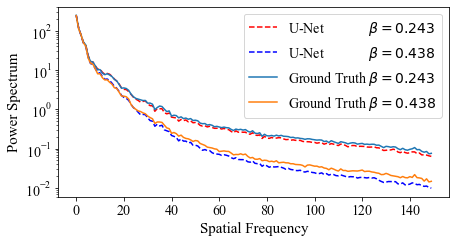

In [393]:
# [STAR] Comparing the Noise Power Spectrum

from scipy import fftpack
import pyfits
import numpy as np
import pylab as py
import radialProfile

index  = 2
image1 = all_result[1]#o1[:, index*256:(index+1)*256]
image2 = all_ground[1]#o2[:, index*256:(index+1)*256]

index  = 5
image3 = all_result[3]#o1[:, index*256:(index+1)*256]
image4 = all_ground[3]#o2[:, index*256:(index+1)*256]


def get_power_spectrum(image):    
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psf2D = np.abs( F2 )**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    psf1D = radialProfile.azimuthalAverage(psf2D)
    return psf1D

t1 = get_power_spectrum(image1)
t2 = get_power_spectrum(image2)

t3 = get_power_spectrum(image3)
t4 = get_power_spectrum(image4)


py.figure(5)
py.clf()

py.semilogy( t1[:150], 'r--', label=r'U-Net             $\beta = 0.243$')
py.semilogy( t3[:150], 'b--', label=r'U-Net             $\beta = 0.438$')

py.semilogy( t2[:150], label=r'Ground Truth $\beta = 0.243$')
py.semilogy( t4[:150], label=r'Ground Truth $\beta = 0.438$')


py.xlabel("Spatial Frequency", fontsize=15)
py.ylabel("Power Spectrum",    fontsize=15)
py.legend(fontsize=14)
py.xticks(fontsize=14)
py.yticks(fontsize=14)
py.show()

In [391]:
print(len(t1))

179


<Figure size 504x252 with 0 Axes>

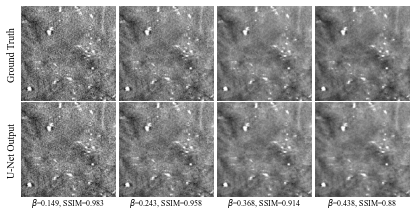

In [379]:
# [STAR] For series of images for a volume with the Labels


f = plt.figure()
plt.rcParams["figure.figsize"] = [7, 3.5]

#gs1 = gridspec.GridSpec(1, 8)
#gs1.update(wspace=0.025, hspace=0.05)

plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(2, 4, constrained_layout=True)
#print(axs)
for i in range(1, 5):
    if i == 1:
        axs[0, i-1].set_ylabel("Ground Truth")
    axs[0, i-1].imshow(all_ground[i-1], cmap='gray')
    #axs[0, i-1].set_title(r'$\beta$='+str(np.round(value_array[i-1], 3)), y=0.95, fontsize=10)
    axs[0, i-1].set_xticks([], [])
    axs[0, i-1].set_yticks([], [])
    axs[0, i-1].spines['top'].set_visible(False)
    axs[0, i-1].spines['bottom'].set_visible(False)
    axs[0, i-1].spines['left'].set_visible(False)
    axs[0, i-1].spines['right'].set_visible(False)
    
for i in range(1, 5):
    if i == 1:
        axs[1, i-1].set_ylabel("U-Net Output")
    axs[1, i-1].imshow(all_result[i-1], cmap='gray')
    axs[1, i-1].set_title(r'$\beta$='+str(np.round(value_array[i-1], 3))+", SSIM="+str(np.round(ssim_array[i-1], 3)), y=-0.15, fontsize=8)
    axs[1, i-1].set_xticks([], [])
    axs[1, i-1].set_yticks([], [])
    axs[1, i-1].spines['top'].set_visible(False)
    axs[1, i-1].spines['bottom'].set_visible(False)
    axs[1, i-1].spines['left'].set_visible(False)
    axs[1, i-1].spines['right'].set_visible(False)
    #axs[1, i-1].set_visible(False)
    #axs[1, i-1].xticks([], [])


#axs.set_xticks([])
#axs.set_yticks([])
#axs[1].set_xticks([])
#axs[1].set_yticks([])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    right=False,
    labelbottom=False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

f.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('ipmi_supp13.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0.08)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show(block=True)

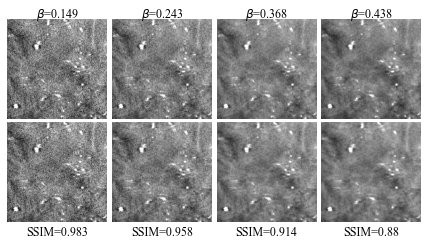

In [366]:
# [STAR] For series of images for a volume


f = plt.figure()
plt.rcParams["figure.figsize"] = [7.5, 5.9]

#gs1 = gridspec.GridSpec(1, 8)
#gs1.update(wspace=0.025, hspace=0.05)

plt.rcParams["font.family"] = "Times New Roman"

for i in range(1, 5):
    f.add_subplot(2, 5, i)
    plt.imshow(all_ground[i-1], cmap='gray')
    plt.title(r'$\beta$='+str(np.round(value_array[i-1], 3)), y=0.95, fontsize=12)
    plt.axis('off')
    
for i in range(1, 5):
    f.add_subplot(1, 5, i)
    plt.imshow(all_result[i-1], cmap='gray')
    plt.title("SSIM="+str(np.round(ssim_array[i-1], 3)), y=-0.2, fontsize=12)
    plt.axis('off')
    
f.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.00001, bottom=0.002)
#plt.subplots_adjust(wspace=0.9)
plt.savefig('ipmi_supp10.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show(block=True)

[0.0, 0.149, 0.243, 0.368, 0.438]


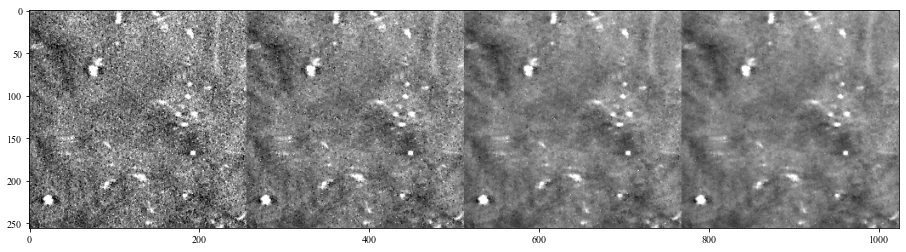

In [272]:
plt.figure(figsize=(20, 4))
plt.imshow(np.concatenate(all_result, axis=1), cmap='gray')
print(tv)

[0.0, 0.149, 0.243, 0.368, 0.438]


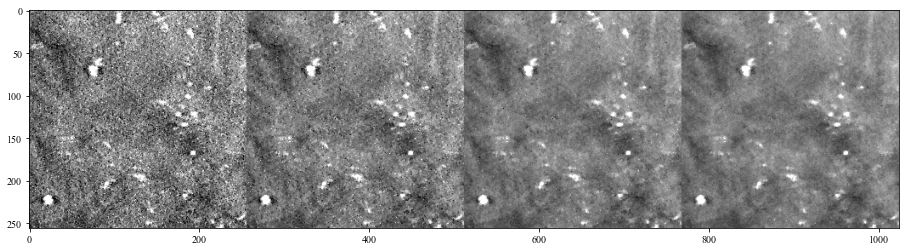

In [273]:
plt.figure(figsize=(20, 4))
plt.imshow(np.concatenate(all_ground, axis=1), cmap='gray')
print(tv)

In [211]:
# [STAR] For obtaining the images for the IPMI paper

allfiles = glob.glob('/media/pranjal/newdrive1/IPMI_recons/*.npy')
#for p in allfiles:
#    print(p)
a = []
a.append(allfiles[3])
a.append(allfiles[1])
a.append(allfiles[8])
a.append(allfiles[5])
#a.append(allfiles[2])
#a.append(allfiles[5])
#a.append(allfiles[8])


all_images = []

for p in a:
    print(p)
    vol = np.load(p)
    vol = np.reshape(vol, [40, 1200, 3000])
    #vol = np.reshape(vol, [3000, 40, 1200])
    vol[vol > 0.1075] = 0.1075
    vol[vol < 0.0925]   = 0.0925
    #break
    all_images.append(vol[17][bx:bx+s, by:by+s].astype('float32'))
    #break

tv1 = [0.0, 0.127, 0.315, 0.434]

/media/pranjal/newdrive1/IPMI_recons/04140608-LE-L-CC_3000x1200x40.4_0.0005_-0.0_100.raw.npy
/media/pranjal/newdrive1/IPMI_recons/04140608-LE-L-CC_3000x1200x40.4_0.0005_-0.127_100.raw.npy
/media/pranjal/newdrive1/IPMI_recons/04140608-LE-L-CC_3000x1200x40.4_0.0005_-0.315_100.raw.npy
/media/pranjal/newdrive1/IPMI_recons/04140608-LE-L-CC_3000x1200x40.4_0.0005_-0.434_100.raw.npy


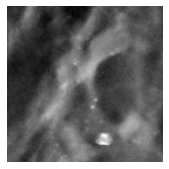

In [228]:
# [STAR] For individual images
plt.figure(figsize=(3, 3)) 
plt.imshow(all_images[3], cmap='gray')
#plt.title(r'$\beta$='+str(np.round(tv1[i-1], 3)), y=0.99, fontsize=12)
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.0001, bottom=0.16)
plt.savefig('temp_1d.png', bbox_inches = 'tight',pad_inches = 0)
plt.show(block=True)

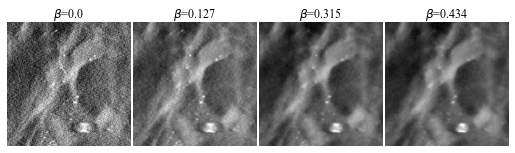

In [217]:
# [STAR] For series of images for a volume

f = plt.figure()
plt.rcParams["figure.figsize"] = [9, 6]

#gs1 = gridspec.GridSpec(1, 8)
#gs1.update(wspace=0.025, hspace=0.05)

plt.rcParams["font.family"] = "Times New Roman"

for i in range(1, 5):
    f.add_subplot(2, 5, i)
    plt.imshow(all_images[i-1], cmap='gray')
    plt.title(r'$\beta$='+str(np.round(tv1[i-1], 3)), y=0.99, fontsize=12)
    plt.axis('off')
    
f.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.0001, bottom=0.16)
plt.savefig('temp1.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)
plt.show(block=True)

(1, 1024, 256)


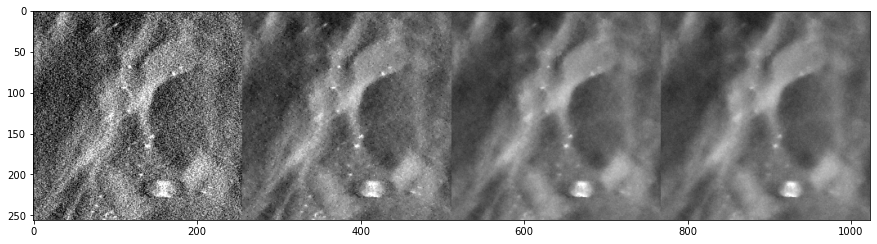

In [203]:
bx = 300
by = 1000
s  = 256

temp = np.concatenate(all_images, axis=1)
print(temp.shape)
plt.figure(figsize=(15, 5)) 
plt.imshow(temp[0].T, cmap='gray')
#plt.imshow(vol[18][bx:bx+s, by:by+s].astype('float32'), cmap='gray')

(1, 1024, 256)


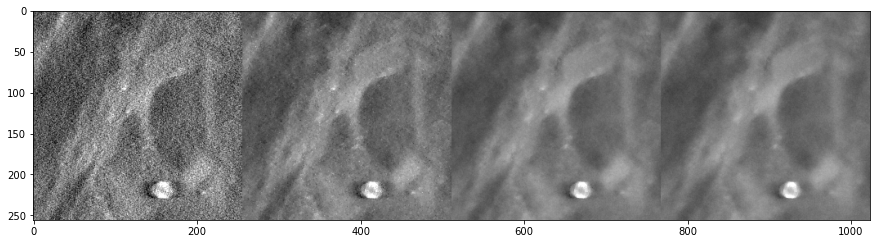

In [154]:
bx = 300
by = 1000
s  = 256

temp = np.concatenate(all_images, axis=1)
print(temp.shape)
plt.figure(figsize=(15, 5)) 
plt.imshow(temp[0].T, cmap='gray')
#plt.imshow(vol[18][bx:bx+s, by:by+s].astype('float32'), cmap='gray')

In [246]:
model.eval()

i = 60
x = x_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
y = y_val_array[i*batch_size:(i+1)*batch_size, :, :, :]
v = v_val_array[i*batch_size:(i+1)*batch_size, :]

x = torch.tensor(x, device=device).float()
y = torch.tensor(y, device=device).float()
v = torch.tensor(v, device=device).float()

output = model(x, v)

output = output.data.cpu().numpy()
x      = x.data.cpu().numpy()
y      = y.data.cpu().numpy()
v      = v.data.cpu().numpy()

print(x.shape, y.shape, v.shape)
print(v.flatten())

(8, 1, 256, 256) (8, 1, 256, 256) (8, 1)
[0.0146 0.0289 0.032  0.0329 0.041  0.0146 0.0289 0.032 ]


In [ ]:
# Code to clean the reconstruction output before calculating SSIM

from skimage import morphology, exposure, io, filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
from scipy import ndimage

a  = np.load('/media/drilnvm/ubuntudata1/WalnutDataRecon/42_0_50_huber.npy').astype('float32')
print(a.shape)

temp            = a[:, 100, :]
temp            = filters.gaussian(temp, sigma=5)

thresh_min      = threshold_minimum(temp)
binary_adaptive = temp > thresh_min
binary_adaptive = ndimage.binary_fill_holes(binary_adaptive).astype('uint8')
cleaned_output  = np.multiply(a[:, 120, :], binary_adaptive)



/media/pranjal/newdrive1/WalnutDataRecon/1_0.0135_50_huber.npy
/media/pranjal/newdrive1/WalnutDataRecon/1_0.0076_50_huber.npy
/media/pranjal/newdrive1/WalnutDataRecon/1_0_50_huber.npy
/media/pranjal/newdrive1/WalnutDataRecon/1_0.0425_50_huber.npy
/media/pranjal/newdrive1/WalnutDataRecon/1_0.0253_50_huber.npy
/media/pranjal/newdrive1/WalnutDataRecon/1_0.0384_50_huber.npy


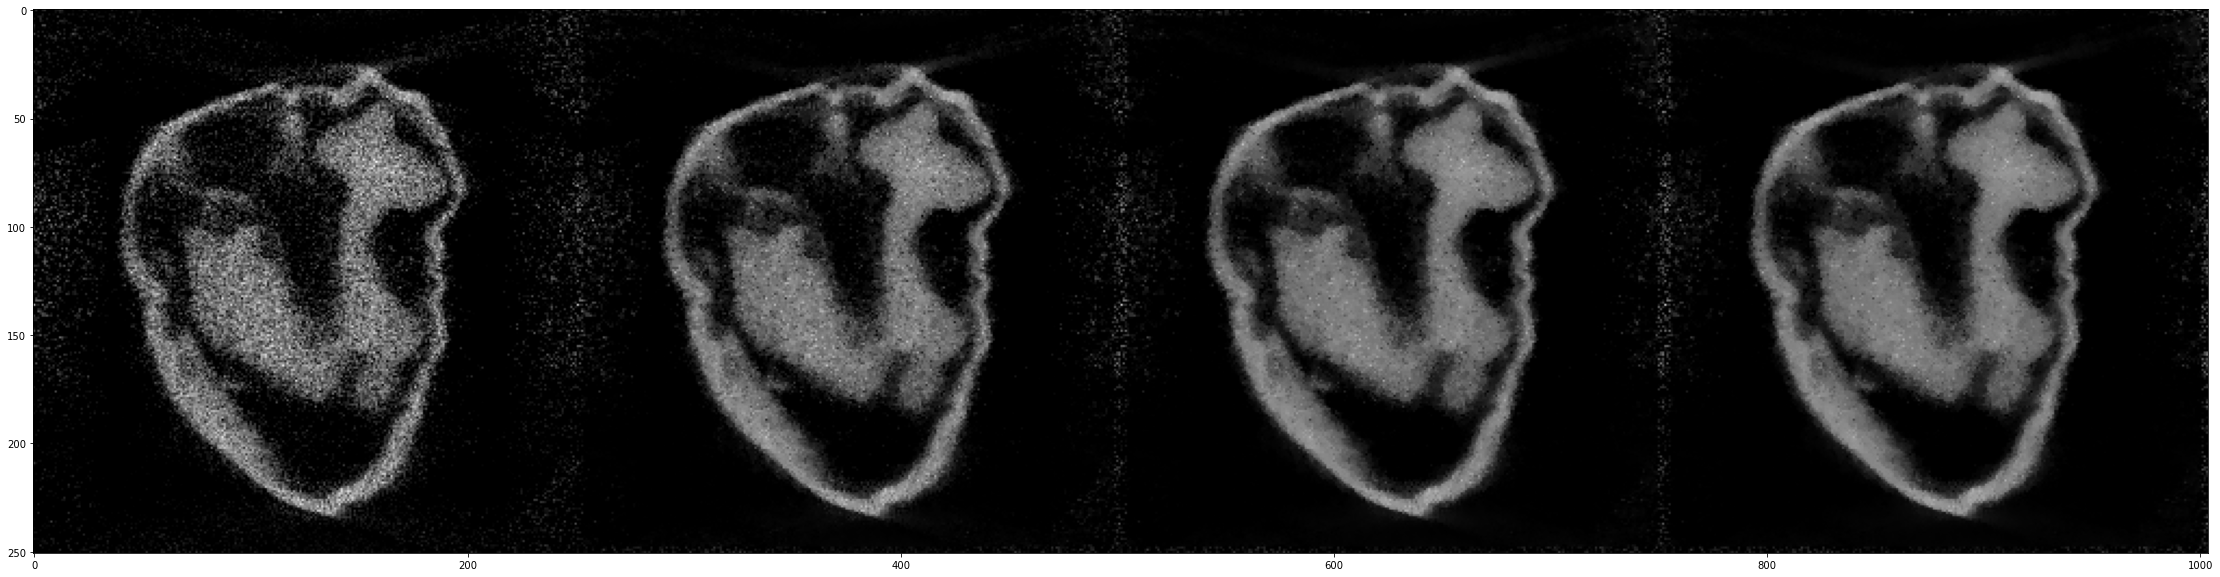

In [15]:
import numpy as np
import glob
import matplotlib.pyplot as plt

if 1:
    allfiles = glob.glob('/media/pranjal/newdrive1/WalnutDataRecon/1_*_50_huber.npy')
    for p in allfiles:
        print(p)

    a = np.load(allfiles[2])
    b = np.load(allfiles[1])
    c = np.load(allfiles[0])
    d = np.load(allfiles[4])
    e = np.load(allfiles[5])
    f = np.load(allfiles[3])

slice_index  = 140
plt.figure(figsize=(40,10))
plt.imshow(np.concatenate([a[:, slice_index, :],  d[:, slice_index, :], e[:, slice_index, :], f[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')
#plt.imshow(np.concatenate([a[:, slice_index, :],  d[:, slice_index, :],  f[:, slice_index, :]], axis=-1).astype('float32'), cmap='gray')

In [65]:
# Reconstruction Code for a given Walnut Case

# select the ID of the sample you want to reconstruct
walnut_id = 1
# select also the orbit you want to reconstruct the data from:
# 1 higher source position, 2 middle source position, 3 lower source position
orbit_id = 2
# define a sub-sampling factor in angular direction
# (all reference reconstructions are computed with full angular resolution)
angluar_sub_sampling = 10
# select of voxels per mm in one direction (higher = larger res)
# (all reference reconstructions are computed with 10)
voxel_per_mm = 5

# we enter here some intrinsic details of the dataset needed for our reconstruction scripts
# set the variable "data_path" to the path where the dataset is stored on your own workstation
data_path = '/media/pranjal/newdrive1/Walnuts/'
# set the variable "recon_path" to the path where you would like to store the
# reconstructions you compute
recon_path = '/media/pranjal/newdrive1/Walnut_recons/'

t = time.time();
print('load data', flush=True)

# we add the info about walnut and orbit ID
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections', 'tubeV{}'.format(orbit_id))
projs_name = 'scan_{:06}.tif'
dark_name = 'di000000.tif'
flat_name = ['io000000.tif', 'io000001.tif']
vecs_name = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# load the numpy array describing the scan geometry from file
vecs = np.loadtxt(os.path.join(data_path_full, vecs_name))
# get the positions we need; there are in fact 1201, but the last and first one come from the same angle
vecs       = vecs[range(0,1200, angluar_sub_sampling)]
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx  = range(1199,-1, -angluar_sub_sampling)

n_pro = vecs.shape[0]

# create the numpy array which will receive projection data from tiff files
projs = np.zeros((n_pro, projs_rows, projs_cols), dtype=np.float32)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# load flat-field and dark-fields
# there are two flat-field images (taken before and after acquisition), we simply average them
dark = trafo(imageio.imread(os.path.join(data_path_full, dark_name)))
flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)

for i, fn in enumerate(flat_name):
    flat[i] = trafo(imageio.imread(os.path.join(data_path_full, fn)))
flat =  np.mean(flat,axis=0)

# load projection data
for i in range(n_pro):
    projs[i] = trafo(imageio.imread(os.path.join(data_path_full, projs_name.format(projs_idx[i]))))

print(np.round_(time.time() - t, 3), 'sec elapsed')

### pre-process data ###########################################################

t = time.time();
print('pre-process data', flush=True)
# subtract the dark field, divide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
projs -= dark
projs /= (flat - dark)
np.log(projs, out=projs)
np.negative(projs, out=projs)
# permute data to ASTRA convention
projs = np.transpose(projs, (1,0,2))
projs = np.ascontiguousarray(projs)
print(np.round_(time.time() - t, 3), 'sec elapsed')

# [STAR] Testing GroundTruthReconstruction.py
import NesterovGradient

orbits_to_recon = [1,2,3]

#### load and pre-process data #################################################

t = time.time();
print('load and pre-process data', flush=True)

# we add the info about walnut
data_path_full = os.path.join(data_path, 'Walnut{}'.format(walnut_id), 'Projections')

projs_name = 'scan_{:06}.tif'
dark_name  = 'di000000.tif'
flat_name  = ['io000000.tif', 'io000001.tif']
vecs_name  = 'scan_geom_corrected.geom'
projs_rows = 972
projs_cols = 768

# Create the numpy array which will receive projection data from tiff files
projs = np.zeros((projs_rows, 0, projs_cols), dtype=np.float32)

# And create the numpy array receiving the motor positions read from the geometry file
vecs           = np.zeros((0, 12), dtype=np.float32)
nb_projs_orbit = len(range(0,1200, angluar_sub_sampling))
# projection file indices, we need to read in the projection in reverse order due to the portrait mode acquision 
projs_idx      = range(1199,-1, -angluar_sub_sampling)

# transformation to apply to each image, we need to get the image from
# the way the scanner reads it out into to way described in the projection
# geometry
trafo = lambda image : np.transpose(np.flipud(image))

# Loop over the subset of orbits we want to load at the same time
for orbit_id in tqdm(orbits_to_recon):
    orbit_data_path = os.path.join(data_path_full, 'tubeV{}'.format(orbit_id))


    # load the numpy array describing the scan geometry of the orbit from file
    vecs_orbit = np.loadtxt(os.path.join(orbit_data_path, vecs_name))
    
    # get the positions we need; there are in fact 1201, but the last and first one come from the same angle
    vecs = np.concatenate((vecs, vecs_orbit[range(0,1200, angluar_sub_sampling)]), axis=0)

    # load flat-field and dark-fields
    # there are two flat-field images (taken before and after acquisition), we simply average them
    dark = trafo(imageio.imread(os.path.join(orbit_data_path, dark_name)))
    flat = np.zeros((2, projs_rows, projs_cols), dtype=np.float32)
    for i, fn in enumerate(flat_name):
        flat[i] = trafo(imageio.imread(os.path.join(orbit_data_path, fn)))
    flat =  np.mean(flat,axis=0)

    # load projection data directly on the big projection array
    projs_orbit = np.zeros((nb_projs_orbit, projs_rows, projs_cols), dtype=np.float32)
    for i in range(nb_projs_orbit):
        projs_orbit[i] = trafo(imageio.imread(os.path.join(orbit_data_path, projs_name.format(projs_idx[i]))))

    # subtract the dark field, devide by the flat field, and take the negative log to linearize the data according to the Beer-Lambert law
    projs_orbit -= dark
    projs_orbit /= (flat - dark)
    
    noise       = random_noise(projs_orbit, mode="poisson")
    projs_orbit = projs_orbit + noise
    
    # take negative log
    np.log(projs_orbit, out=projs_orbit)
    np.negative(projs_orbit, out=projs_orbit)
    # permute data to ASTRA convention
    projs_orbit = np.transpose(projs_orbit, (1,0,2))

    # attach to projs
    projs = np.concatenate((projs, projs_orbit), axis=1)
    del projs_orbit

# from skimage.util import random_noise

#for k in range(360):
#    p     = projs[:, k, :]
#    #noise = random_noise(p, mode="poisson")
#    #noise = np.random.poisson(p)
#    #noise = np.random.normal(0, 0.1, p.shape)
#    #p     = p + noise
#    projs[:, k, :] = p
projs = np.ascontiguousarray(projs)

load data
0.229 sec elapsed
pre-process data
2.736 sec elapsed
load and pre-process data


100%|██████████| 3/3 [00:43<00:00, 14.52s/it]


In [51]:
W = astra.OpTomo(cfg_agd['ProjectorId'])
print(W)
print(W.FP)

<268738560x15813251 OpTomo with dtype=<class 'numpy.float32'>>
<bound method OpTomo.FP of <268738560x15813251 OpTomo with dtype=<class 'numpy.float32'>>>


In [24]:
### compute FDK reconstruction #################################################

t = time.time();
print('compute reconstruction', flush=True)

# size of the reconstruction volume in voxels
vol_sz  = 3*(50 * voxel_per_mm + 1,)
# size of a cubic voxel in mm
vox_sz  = 1/voxel_per_mm
# numpy array holding the reconstruction volume
vol_rec = np.zeros(vol_sz, dtype=np.float32)

# we need to specify the details of the reconstruction space to ASTRA
# this is done by a "volume geometry" type of structure, in the form of a Python dictionary
# by default, ASTRA assumes a voxel size of 1, we need to scale the reconstruction space here by the actual voxel size
vol_geom = astra.create_vol_geom(vol_sz)
vol_geom['option']['WindowMinX'] = vol_geom['option']['WindowMinX'] * vox_sz
vol_geom['option']['WindowMaxX'] = vol_geom['option']['WindowMaxX'] * vox_sz
vol_geom['option']['WindowMinY'] = vol_geom['option']['WindowMinY'] * vox_sz
vol_geom['option']['WindowMaxY'] = vol_geom['option']['WindowMaxY'] * vox_sz
vol_geom['option']['WindowMinZ'] = vol_geom['option']['WindowMinZ'] * vox_sz
vol_geom['option']['WindowMaxZ'] = vol_geom['option']['WindowMaxZ'] * vox_sz

# we need to specify the details of the projection space to ASTRA
# this is done by a "projection geometry" type of structure, in the form of a Python dictionary
proj_geom = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)

# register both volume and projection geometries and arrays to ASTRA
#vol_id  = astra.data3d.link('-vol', vol_geom, vol_rec)
#proj_id = astra.data3d.link('-sino', proj_geom, projs)

vol_id  = astra.data3d.create('-vol', vol_geom)
proj_id = astra.data3d.create('-sino', proj_geom, projs)


#astra.create_projector('cuda3d', proj_geom, projs)

# finally, create an ASTRA configuration.
# this configuration dictionary setups an algorithm, a projection and a volume
# geometry and returns a ASTRA algorithm, which can be run on its own
# cfg_fdk = astra.astra_dict('FDK_CUDA')
# cfg_fdk['ProjectionDataId'] = proj_id
# cfg_fdk['ReconstructionDataId'] = vol_id
# cfg_fdk['option'] = {}
# cfg_fdk['option']['ShortScan'] = False
# alg_id = astra.algorithm.create(cfg_fdk)

compute reconstruction


In [ ]:
# finally, create an ASTRA configuration.
# this configuration dictionary setups an algorithm, a projection and a volume
# geometry and returns a ASTRA algorithm, which can be run on its own
cfg_fdk = astra.astra_dict('FDK_CUDA')
cfg_fdk['ProjectionDataId']     = proj_id
cfg_fdk['ReconstructionDataId'] = vol_id
cfg_fdk['option'] = {}
cfg_fdk['option']['ShortScan'] = False
alg_id = astra.algorithm.create(cfg_fdk)

# run FDK algorithm
astra.algorithm.run(alg_id, 1)

# release memory allocated by ASTRA structures
astra.algorithm.delete(alg_id)
astra.data3d.delete(proj_id)
astra.data3d.delete(vol_id)

print(np.round_(time.time() - t, 3), 'sec elapsed')

In [5]:
proj_geom        = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

In [16]:
print(proj_id)
W = astra.OpTomo(proj_id)

#W                = astra.OpTomo(proj_id)

7


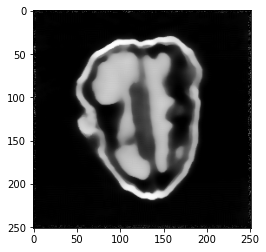

In [159]:
# 0.1
plt.imshow(vol_rec[:, 160, :], cmap='gray')

In [163]:
# Reconstruction Algorithm Code Step by Step

from numba import jit
from numba import njit, prange

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)

@njit(parallel=True)
def G_Huber_prior_sart(estbuf, delta):
    priorbuf = np.zeros(estbuf.shape)
    cent     = 1
    
    for ind_x in prange(3, estbuf.shape[0]-3):
        for ind_y in prange(3, estbuf.shape[1]-3):
            for ind_z in prange(3, estbuf.shape[2]-3):
                # For All the Voxels
                
                for ind_nr_z  in range(ind_z-1, ind_z+2):
                    for ind_nr_y in range(ind_y-1, ind_y+2):
                        for ind_nr_x in range(ind_x-1, ind_x+2):
                            distance = np.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                            
                            if (distance == 0.0):
                                distance = 1.0
                            
                            #if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                            #    ind_nr = int(ind_voxel)
                            #else:
                            #    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                            
                            diff        = estbuf[ind_x][ind_y][ind_z] - estbuf[ind_nr_x][ind_nr_y][ind_nr_z]
                            denominator = np.sqrt(1.0+(diff/delta)*(diff/delta))
                            priorbuf[ind_x][ind_y][ind_z] = priorbuf[ind_x][ind_y][ind_z] + diff
                            #priorbuf[ind_x][ind_y][ind_z] = priorbuf[ind_x][ind_y][ind_z] + (1.0/distance)*diff/denominator
    return priorbuf

proj_id      = astra.data3d.link('-sino', proj_geom, projs)
proj_arr     = astra.data3d.get_shared(proj_id)#.flatten()

proj_geom        = astra.create_proj_geom('cone_vec', projs_rows, projs_cols, vecs)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

vol_rec      = np.zeros(vol_sz, dtype=np.float32)
only_ones_v  = np.ones(vol_rec.shape, dtype='float32')
only_ones_p  = np.ones(proj_arr.shape, dtype='float32')

delta = 0.001
niter = 100
beta  = 0.01

for j in range(0, niter):
    print("Iteration ", j)
    
    prior     = G_Huber_prior_sart(vol_rec, delta)
    
    p         = W.FP(vol_rec)
    diff      = proj_arr - p
    
    cost = np.square(diff)
    print("Cost is ", np.sum(cost), prior.shape, vol_rec.shape)
    
    temp_R    = W.FP(only_ones_v)
    diff      = my_divide(diff, temp_R)
    
    temp_back = W.BP(diff)
    temp_C    = W.BP(only_ones_p)
    vol       = my_divide(temp_back, temp_C)
    vol       = np.nan_to_num(vol)
    
    #vol[vol == np.nan] = 0
    
    vol      = np.reshape(vol, vol_rec.shape)
    vol_rec  = vol_rec + vol- beta*prior
    vol_rec[vol_rec < 0] = 0
    #print(temp_R.shape, temp_back.shape, temp_C.shape, p.shape, proj_arr.shape)
    #p = np.reshape(p, [detCols, 25, detRows])
    #print(p.shape, temp_back.shape)

#vol[vol == np.nan] = 0

Iteration  0
Cost is  43434828.0 (251, 251, 251) (251, 251, 251)
Iteration  1
Cost is  9987929.0 (251, 251, 251) (251, 251, 251)
Iteration  2
Cost is  7673575.5 (251, 251, 251) (251, 251, 251)
Iteration  3
Cost is  6347395.0 (251, 251, 251) (251, 251, 251)
Iteration  4
Cost is  5492666.5 (251, 251, 251) (251, 251, 251)
Iteration  5
Cost is  4915728.0 (251, 251, 251) (251, 251, 251)
Iteration  6
Cost is  4512524.5 (251, 251, 251) (251, 251, 251)
Iteration  7
Cost is  4218172.0 (251, 251, 251) (251, 251, 251)
Iteration  8
Cost is  3993442.5 (251, 251, 251) (251, 251, 251)
Iteration  9
Cost is  3815202.5 (251, 251, 251) (251, 251, 251)
Iteration  10
Cost is  3669376.2 (251, 251, 251) (251, 251, 251)
Iteration  11
Cost is  3547098.0 (251, 251, 251) (251, 251, 251)
Iteration  12
Cost is  3442587.2 (251, 251, 251) (251, 251, 251)
Iteration  13
Cost is  3351984.8 (251, 251, 251) (251, 251, 251)
Iteration  14
Cost is  3272555.0 (251, 251, 251) (251, 251, 251)
Iteration  15
Cost is  3202272.5 (

In [40]:
#print(vol_rec.shape)

(251, 251, 251)
